In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from collections import Counter
import itertools
import requests

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from tensorflow import keras

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Eren\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Eren\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Eren\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [14]:
dataset_path = "../dataset/dataset.csv"
df = pd.read_csv(dataset_path)

In [15]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [16]:
df = df.drop_duplicates(subset="text")
df

,text,label
0,There are alot reasons to keep our the despise...,0
1,Driving smart cars that drive by themself has ...,0
2,"Dear Principal,\n\nI believe that students at ...",0
3,"Dear Principal,\n\nCommunity service should no...",0
4,My argument for the development of the driverl...,0
...,...,...
187218,Today's society is ever-evolving and the role ...,1
187219,The ever-evolving world of technology has chan...,1
187220,Fostering a Rescue Dog: Gaining Unconditional ...,1
187221,The importance of a solid foundation in educat...,1


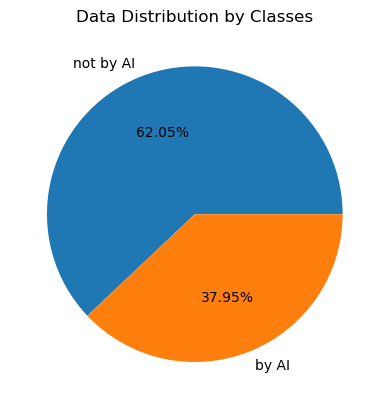

In [17]:
grouped_df = df[["text", "label"]].groupby(by="label")
class_count = grouped_df.count()
 
plt.pie(np.squeeze(class_count.values), labels=["not by AI", "by AI"], autopct='%1.2f%%')
plt.title("Data Distribution by Classes")

plt.show()

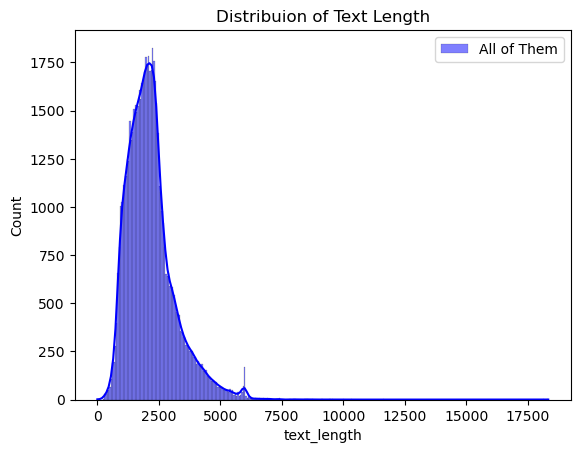

In [18]:
df['text_length'] = df['text'].apply(len)

sns.histplot(df['text_length'], color="blue", label='All of Them', kde=True)

plt.title("Distribuion of Text Length")
plt.legend()
plt.show()

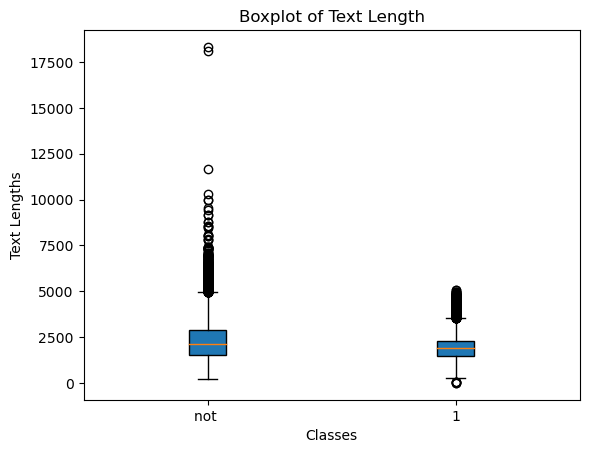

In [19]:
plt.boxplot([df[df["label"]==0]["text_length"], df[df["label"]==1]["text_length"]], vert=True, patch_artist=True, labels=["not ", "1"])

plt.xlabel("Classes")
plt.ylabel("Text Lengths")
plt.title('Boxplot of Text Length')
plt.show()

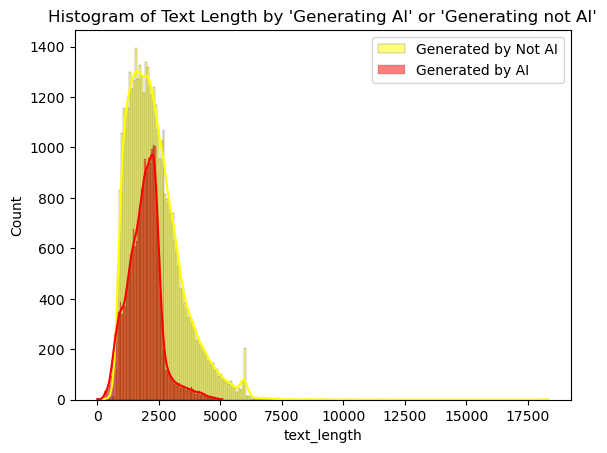

In [20]:
sns.histplot(df[df["label"]==0]['text_length'], color="yellow", label='Generated by Not AI', kde=True)
sns.histplot(df[df["label"]==1]['text_length'], color="red", label='Generated by AI', kde=True)

plt.title("Histogram of Text Length by 'Generating AI' or 'Generating not AI'")
plt.legend()
plt.show()

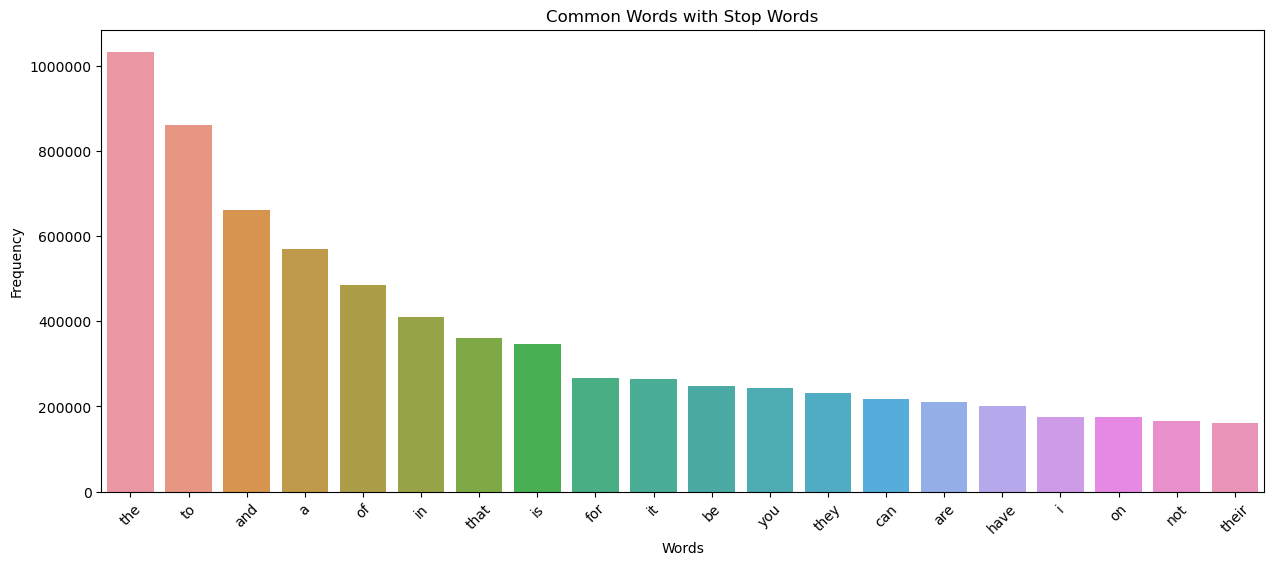

In [21]:
## Common Words with Stop Words

joined_text = " ".join(df["text"].values).lower()
words = joined_text.split()
word_freq = Counter(words)
common_words = word_freq.most_common(20)

# Plot the most common words
plt.figure(figsize=(15, 6))
sns.barplot(x=[word for word, freq in common_words], y=[freq for word, freq in common_words])

plt.ticklabel_format(style="plain", axis="y")
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title("Common Words with Stop Words")

plt.show()

## Preprocess

In [75]:
## This part downloads a larger stopword list. Some missing stopwords are added by hand.

url_link = "https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt"
stopwords_list = requests.get(url_link).content
stopwords_list = stopwords_list.decode().splitlines()

stopwords_list.append("n't")
stopwords_list.append("'s")
stopwords_list.append("'re")
stopwords_list.append("'m")

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize          
from autocorrect import Speller

class LemmaTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`']
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, doc):
        word_list = []
        
        spell = Speller(lang='en')
        print(doc)
        for word in word_tokenize(doc):
            lemmatized_word = self.lemmatizer.lemmatize(word,pos="n")
            lemmatized_word = self.lemmatizer.lemmatize(lemmatized_word,pos="v")
            lemmatized_word = self.lemmatizer.lemmatize(lemmatized_word,pos="a")
            lemmatized_word = self.lemmatizer.lemmatize(lemmatized_word,pos="r")
            #lemmatized_word = self.lemmatizer.lemmatize(self.lemmatizer.lemmatize(word,pos="v"), pos="n")
            corrected_word = spell(lemmatized_word)
            word_list.append(corrected_word)
            
        return word_list   
            
        #return [self.lemmatizer.lemmatize(self.lemmatizer.lemmatize(t,pos="v"), pos="n") for t in word_tokenize(doc)]

def lemmatization(text):
    return [lemmatizer.lemmatize(w, pos="n") for w in text ]

def tokenize_df(df:pd.DataFrame):# -> np.ndarray :
    lemma_tokenizer = LemmaTokenizer()
    
    df["tokenized_text"] = df["text"].replace(r"\n\n?", " ", regex=True) ## removes \n or \n\n
    df["tokenized_text"] = df["tokenized_text"].replace(r'[?|.|,|\\"|!|#|$|%|&|\\|\}|\{|\]|\[|\)|\(|¨|~]+', " ", regex=True) ## removes "." or ","

    df["tokenized_text"] = df["tokenized_text"].replace(r"\d+", "", regex=True)
    df["tokenized_text"] = df['tokenized_text'].replace('[^\w\s]','')
    
    #df["tokenized_text"] = df["tokenized_text"].replace(r'[^a-zA-Z ]', '', regex=True)
    filter_char = lambda c: ord(c) < 256
    
    df["tokenized_text"] = df['tokenized_text'].apply(lambda s: ''.join(filter(filter_char, s)))
    
    df["tokenized_text"] = df["tokenized_text"].apply(lambda each : each.lower())
    
    df.reset_index(drop=True, inplace=True)
    
    tfidf = TfidfVectorizer(stop_words=stopwords_list, tokenizer=lemma_tokenizer)
    
    X = tfidf.fit_transform(df.iloc[:1000]["tokenized_text"].values)
    
    print(len(tfidf.get_feature_names_out()))
    print(tfidf.get_feature_names_out())
    return X, tfidf.get_feature_names_out()

X, features = tokenize_df(df)

really
wont
causes
it's
3d
there's
viz
ur
value
id
bc
fc
un
shall
p
dj
didn't
od
pt
she'd
sm
back
oi
able
changes
eg
thanks
cannot
o
rj
cq
aren't
la
whole
wasn
quite
look
selves
why's
could
indicate
thus
they're
dc
especially
rt
iq
course
shouldn't
substantially
thank
thats
cit
they've
thereto
etc
appropriate
km
taken
heres
noted
later
youd
least
www
needn't
concerning
sixty
sl
however
under
et-al
necessary
mostly
said
nr
kept
wa
i'll
might
0o
showns
let's
seemed
and
top
trying
xt
seems
available
despite
happens
similar
whim
iz
kg
ne
wed
brief
take
volumtype
dx
m2
want
where's
apparently
u201d
more
usefulness
insofar
com
yj
hereafter
lo
put
x
ey
she's
ten
itself
wasnt
'm
actually
exactly
other
go
cv
saw
pd
e
for
we've
bx
biol
neither
welcome
anything
ho
with
i7
el
sc
him
haven't
suggest
he'll
ft
ad
ups
ps
currently
hasn't
anyone
act
hereby
throug
os
same
haven
mt
well
par
bt
rc
ej
specify
xl
going
tell
whereby
xj
oc
whether
sq
aj
ow
associated
se
through
help
though
ti
keeps
inward
you

C:\ProgramData\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'ve", '0', 'abs', 'accord', 'add', 'affect', 'ai', 'associate', 'bio', 'change', 'concern', 'correspond', 'doe', 'fifty', 'follow', 'good', 'greet', 'ha', 'happen', 'hide', 'ignore', 'late', 'note', 'omit', 'owe', 'pa', 'place', 'provide', 'regard', 'relate', 'research-article', 'result', 'send', 'sha', 'tend', 'thick', 'win', 'word'] not in stop_words.
  warnings.warn(


there are alot reasons to keep our the despised method of choosing the president  the first reason is because certainty of outcome  in the text its states that  the reason is that the winning candidate's share of the electoral college invariably exceeds his share of the popular vote  another example from the text is  obama  he recieved   percent of the electoral vote compared to only   percent of the popular votes cast for him and romney  because all of the states award electoral votes on a winner-take-all basis  another reason is that the electiral college requires a presidential candidate to have trans-regional appeal in that case  no region has enough electoral votes to elect a president  a solid regional favorite such as romney was in the south   has no reason to campaign in those states because of the poor economy and because its not a wealthy state  he wont be able to campaign heavily  so he left with no votes and would have to find his electoral college votes in a more suitable 

studying venus is dangerous but there is good insight we can find in this  first in  the challenge of exploring venus  the author says  earth's  twin  venus is the closest planet to earth in terms of density and size  since it has a lot in common with earth it is good to have a litle insight on this planet  in the article it says that  the planet has a surface of rocky sediment and includes familiar features sich as valleys  moutains  and craters  this shows how much earth and venus have incommon  this also gives us an opertunity to take a planetary visit to venus in the future  despite the dangers it could cause on someone  next  in the reading it says that venus has  a thick atmosphere of almost  percent carbon dioxid blankets  this is one example of how dangerous venus is  in the article is says  also notable  venus has the hottest surface temperatue of any planet in our solar system  even though mercury is closer to the sun  this is another example of how dangers venus is  however 

studying science and history at generic_school offers two very different experiences  each with its own advantages  science is a constantly evolving field  with new advances and techniques being discovered daily  the school provides expert guidance and modern equipment  making it an ideal place to explore the complex theories and technologies of the subject  in contrast  history offers an opportunity to delve into the past and investigate the origins of our civilization and culture  through lectures and field trips  generic_schools expert faculty provides students with a solid foundation of knowledge in the subject while also allowing them to study and discuss unique interpretations of traditional narratives   both science and history have their advantages  but in the end it comes down to each individual students interests and goals  if you are passionate about understanding the complexities of our world  then studying science is the perfect choice  if  on the other hand  you enjoy del

dear principle  it is obvious that community service is an important thing in a town or city  that benefit the location in many different ways  for example  cleaning up a neighborhood makes it look more appealing  in turn makes for a healthy environment for not only children but for everybody  but  it also depends on who is doing the work for the place and why they are doing the work  some people are required because they are charged with a crime and their sentence was to serve however many hour  days  etc of community service  to me  not only is this the most honest work but this person could pose a serious threat to the community under the circumstances of what they have done  another example would be for school  if getting into a certain school requires a person to have to do a certain amount of community service  that is a very important for not only the student  but it also serves a good purpose for the community  not to mention  a schoolboy really does not cause someone to fear f

dear senatoris it posible for you to change the electoral college to election by popular vote for the president of the united states because its better acording to source one  the electoral college consists of  electors a majority of  electoral votes is required to elect the president  thats alot of votes that electoral college needs  in source two it says  over  percent of voters would prefer a direct election to the kind we have now  more people prefer the direct vote because under the electoral college system voters vote for for a slate of electors who in turn elect the president  acording to the article in reason one in  obama received   persent of the electoral vote compared to   percent of popular votes for him and romeny  because almost all states award electoral college votes on a winner- takes-all basis  for example in reaosn five  nixon in  and clinton in  both had only a  percent plurality of the popular votes while winning a majority in the electoral college  and  electoral

in the story the author gives us reasonable decisions on why we should go to venus  it forms like earth and its clled the earth  twin sister  the author provides a lot of information  one of them states   may well once have been the most earth-like planet in our solar system  long ago venus was probably covered laregley with oceans and coul have supported various forms of life  this cold very well be a lot like earth  there are sea level just like earth and there   familiar features such as valleys  mountains and craters these areall the same thing that earth has it also says that this venus could have very well had ocean covering all of it  the atricle states that they are going on missions and gettin machines to go and figure out why venus is so much more life-like earth  the nnational aeronautics and space administration  nasa  is trying to do visits with humans to see if they can live there becuase it states that   inot easy conditions  but it is survivable for humans which very we

when you live in the united states  you use cars everyday  so you wouldnt understand the positive impacts of limiting car usage has on everyday life  some small towns in germany  paris  and colombia are car-free citys  in the passage in german susburb  life goes on without cars   writen by elisabeth rosental  she tells her readers that a suburb in germany  vauban  has street parking  driveways  and home garages generally forbidden  rosenthal states that not having a car can actually bring happiness   'when i had a car i was always tence  i'm much happier this way ' said heidrun walker  in the second article  paris bans dring do to smog   by robert duffer  he tells the reader about the struggles paris faced with polution in the air  he states that they made a system where one day they would have even licence plate number stay home one day and the odds would stay home the next  after trial and error  they came up with a solution  and it helped the smog go away  if cars were banned comple

wyat gibson  former scientist from nasa    today  spacecraft one has captured a image to what looks to appear as a face  scientist figured it was just another martain mesa   only this one photo had unusaul shadows that made it look like an egyptain pharoh  i predicted that it must have a degree of surpise among mission controllers back at the jet propulsion lab when the face appeared on the monitiors  some other scientist belived the face was an alien artfact  i snapped a picture ten times sharper than the oraginal viking photos  i have done lots of reaserch  and revealed a natural landform  i reasched the photo a lot more  after a lot of rearch  i decoved that there was no alien monument after all  we decieded that we still did not have enough evedience  perhaps  alien markings were hidden by haze  still there is no evedience as we continued  after more and more reasch  there is still no alien monument  we decovered that the picture is acually the martian of a butte or mesa  they are 

dear principal i agree we should clean up the entry school in end up clean like a whistle  the principal should lets take some breaks once for a while  when school is over we should stay at school until : p  m  therefore cleaning up the liter and stuff off the ground and throw it away in the trash can  we should have a break at :  to : p  m  that gives us plenty of time for a break  but  let some people to go home so they can watch some of their favorite shows and play their video games  once for a while they will come back help us because they did all their chores and their's nothing on tv  i will go home because i have to do chores and feed my animals  plus sometimes i might have a bad day and want to get away from people  in a few minutes i would get over with it come back to school to make it better  i don't want anybody to come to this school and say   this school doesn't look right because all this litter and trash all around the campus   i would get up change the school picking 

the neighboring planet to earth  known as venus has been considered a land of danger  this however  does not stop astronaunts from searching for the unknown answers behind this magnificent planet  venus represents itself hotter in tempature than mercury  the closest planet  and is known not to be hospitible to any outside objects  this essay will be explaining few of the reasons why venus is in fact an intresting discovery in the universe  and depict why it is yet so dangerous  the first reason why venus is a worthy pursuit towards the information it consist about  is because if nasa were able to test rocks and other materials  then it would impact the history of science  science is an amazing attribute to society and if nasa could develop the technology to be able to enter the venus atmostphere then all the lost questions will be answered  it is also  very similar to earth  if the danger of venus could be determined to an exact pin point then we could use the results to fix and calcul

there is some consensus of when it comes to if student should attend classes from home by way of online or video conferencing  although some people think student should not take online clasess  neverthless  there is some people who agrees with that situation in education  because  the online clasess are time limit so they can use their time wisely in other things and student who have to face transportation problem every morning  clasess from home will make their life more easier  to bging taking online clasess from home is much more valuable because those clasess are time limited  so that student can use their other time wisely  for example  usually online clasess have seseaons which is fixed time  one course must have to be done by that seseaon time  in that case student can plan their study in a day and do a job in their free time  in usa most of the student have to take loan to finish thier education  so doing a job while taking an online course will help a lot with those loan terms

dear principal  community service is a very helpful thing towards the community  if its cleaning up after a high school game or planting a tree it will all have a positive outcome  i think it would be a good idea to have us do community service because there are a lot of things that need help being done and there are so many kids at school  if they all work together they could easily clean up a school step by step  some children fail to see the opportunity that you are faced with and do not recognize that they could take ten minutes from their day for a good cause  i see why you are struggling with this decision  some kids might act up and also write letters to you about why we should not have to do anything  others want to help the town  and show that they care  i personally would love to help you out  i do not do community service a lot and only have once during school one year  but i understand that some things need done from time to time  during school my teacher had us go out to t

hey  i'm like totally stoked to be writing this essay   i know  i know  it's not exactly the most exciting topic  but i promise i'll do my bestest to make it interesting   so  let's talk about how problems can actually be a chance for someone to do their best  like  think about it  when things get tough  we're forced to dig deep and find a way to overcome them  it's like  when you're running a marathon and you hit that wall  but you know you can't give up or you'll never finish  you push through the pain and keep going  and it's like  boom  you crush that wall and feel so good about yourself   and it's not just about running marathons  dude  it's about life in general  when we face problems  we have two choices: we can either let them get us down and give up  or we can use them as an opportunity to show what we're made of  like  when i had to move to a new school last year  i was totally nervous and didn't know anyone  but instead of feeling sorry for myself  i decided to make the most

dear state senator  many people do not think that the electoral college is not fair  or exact  in fact  people wanted to boycott it in   i suggest that we change it to election by popular vote for the president of the united states  it is fair to the candidates and to the people of our country  and we should be able to choose our president  not the electors  also  if we keep the electoral college  voting will be unfair and it only makes people want to stop voting  i will explain to you the details of these reasons why we should change it in the rest of my letter  to begin with  we should change to popular voting because it is fair to everyone  the people want a fair election  presidents can be chosen wisely by the people  and candidates will be chosen fairly  people want a safe election  so that they can feel safe and protected with the president that we all chose together  it is only unfair to not let us have the advantage of expressing our own opinions  that is a reason why we should

some students don't shre there emotions because something bad or wrong happened in there life they don't want to talk about  why bring it out of them with technology  in paragragh  it gives intrusctions on what to do when looking in the mirror  then goes on to talk about how those intrusctions show a happy face and what those muscle actions show if a person shows a genuine smile or a foced smile  if a person was told to follow those instructions wouldn't that be considered a forced smile  what if a student has a bad day during school and in a lab they have to follow these instuctions in a mirror that would be a foced smile  i think that we should not deal with others emotions or try to figure them out because it there life and if they want to let there emtions out they can  im not trying to say that you should keep your emotions inside and struggle with them  im saying that a person shouldn't be watched all the time and studied to find there emotions  in paragraph  it talks about in an

the author supports this idea that studying venus is worthy pursuit despite the dangers because venus is the second planet from our sun  while venus is simple to see from the distant away but still safe   earth  venus  and mars are the planetary neighbor  that will go aroud the other planets  venus is very close to the sun   venus is just like a evening star that they call it in different places  each previous mission was unmanned  and for more than a few hours  they always tried to watch venus the planet to see if there was anything new or they need to know something about it   venus is kinda hot just like the sun becuase they are both close together  even the clouds are highly corrosive sulfuric acid in venus's atmosphere  the conditions can get far more extreme then humans which can get very bad  the national aeronautics and space administration has one particularly compelling idea for sending humans to study venus  venus will be able to allow scienctists to see more thing and allow

would you like someone to be able to read your emotions  reading someone's emotions ican help you know that they need some help  here are some reasons why it is good to be able to read emotions  reading the emotions of someone is amazing and should be used  in the article  dr  huang stated   the facial expresions for each emotion are universal  even though individuals often show varing degrees of expression  this shows why it is important to know how people feel when they are being taught something they don't understand  reading a person's emotions can be complicated when you're with a friend  the article states    she's  the mona lisa   percent happy   percent disgusted   percent fearful  and  percent angry  this says that when the mona lisa was painted  she had  different emotions  when your with friends  it is unclear how they feel  this research shows why it is necesary to read the emotions of somebody to know how they feel  this face reading software can help people who need help 

it said the cowboys played baseball volleyball table tennis tornaments fencing boxing reading whittling and games that help pass time so i think he was like showing people and telling people about its so fun and it was like about world war  and like that and told him it would be awesome and fun and all like that and he was telling a hole bunch of people to join and that it would be really fun and it was gponna be about the old days and like thatand we will be doing some cool stuff about it and fun building things and like that and that your going to learn some interesting stuff and maybe you have not learned about it yet but you will learn and get more better at it so just in case you took a test you would probably know alot more and get the test done easy and probvably get an a plus on it then if you keep going to it you will get probably get really smart that you could probably on get in the hardest class in school you would feel so smart but it would probably be a lot harder in the 

school is one of the most talked about and very differently viewed topics of today  some people like the idea of waking up early  going to school  and learning in tons of different ways  that's a select few people  but  most don't see a reason to coming to school and learning like that when you can learn the way you want too and have a school schedule that best fits you  schooling online is great because it can be more relaxing and help with time management  it gives kids time to work on their own and pace themselves how they see fits best to their academic needs  and it allows freedom to express how they learn the best without fear of judgement from peers  school from home can be more relaxing because kids don't have to worry about missing the bus or driving to school on time  kids can get up and get a good amount of sleep without rushing to get ready within a certain amount of time  it allows kids to also practice and get a good grip on time management  if kids are running off to sch

there are many ways a person can get from one place to another whether it is by bus  plane  train or car  car and truck transportation is one of the leading causes in air polution  ruducing the use of cars will be beneficial to the public  not only on the streets  but to the citizens themselves  to start off  the reduction of cars on the streets will cause less stress to the people who drive them  for example  in source  it shows how a woman is happier and the loss of her car has changed her life for the better   when i had a car i was always tense  i'm much happier this way  she says  the tension of being in a car and waiting in traffic can be stressful and cause people to get impatient  grumpy  and even irritated  the woman proves that her life has changed because she doesn't have to go through that anymore  her car-less life is the one that makes her happy  besides that  not only does car reduction cause better mood for people  but it also lessens the air pollution and makes the env

planning a summer project can be a difficult task for anyone  however  for school summer projects  teachers should be the ones to plan out a summer project for the students  teacher's have been proven to more knowledgeable then their younger counterparts  teachers are just overall more knowledgeable about how to teach their students  in order for teachers to better prepare their students for their class; a summer project is best left to the teachers to plan out  the reason being that teachers should have a pretty good idea of they should be teaching for that year's education  centering the project on what teachers will be teaching; would better help understand where their students stand on certain subjects of that class  not to mention  teachers also have more experience in what students should be learning because at one point they were students themselves  being a teacher most certainly means that teachers have gone through learning experiences that they thought had gone well  or mayb

the use of facial action coding system could be a good thing to use in school  it also can be used for help better how teacher do things  at can also help a pyschologist find students with problems or mental issues  another good use for it is could help the students in there ability to act in acting classes  first reason why it could be a good thing for schools is that you can use the system to check if the students are bored or confused  so you can change how a teacher teaches in a different style  it also could change how the students learn  in the text i says this '' then it could modify the lesson  like an effective human instructor '' it would be good to use to help students learn what are some of facial expression and learning what muscle cause that movement  another reason why it would be good to use the system is to use in acting class  a lot of school have classes such as acting  drama  and threater  how this would benfit a student is it would help then try to get the facial e

students would definitely benifit from being able to take classes in home by the way of online classrooms  especially in the time we are in now  the coronavirus is traveling through the world and school is one of the biggest ways of continually spreading it  if students get the option to take classes online and in the home  they would still be getting their education and keeping everyone safe  another reason is if students have to take a day off for a reason which could be being sick  family event  or just wanting to stay home  taking the class online would stop them from getting behind in the class work and keeping up with everyone else in the class  some say that the students should only be learning in the classroom should not have to take those matters in the home  also if students missed school and could just take an online class to keep up  that would be a big reason for students to stay home and not come to school  because why deal with the stress of school when you have it all i

i would want the electoral vote to be changed or to change the election by popular vote  because the electoral college does have some things in it that are procieved as wrong and people want to change about it  and honestly i think i would be alot better if it was just the popular vote because then mre people would be satisfied with who their president is  knowing that its someone they voted for ad not someone in which the electoral college votes for and decides to make the president  some presidents win the popular vote but still lose the presidency because they didnt get enough electoral votes  i would prefer a direct vote from popular votes  i dont think it is that much fair if someone wins the popular vote but still dosent get picked to be the president because of the electoral college  in the electoral college voters dont vote for the president they vote for the state electors and thats not want they should be voting for they should be able to directly vote for the president that 

participating in extracurricular activities can reward you with many advantages  schools provide many clubs and sports teams like debate club football etc  having a hobby can help reduce electronic use which allows more productivity  joining a curricular activity allows students to make new friends and find a new hobby  extracurricular activities are important because it can help students decrease stress and help them become more engaged at school and life  students collect a lot of stress from workloads of homework to chores around the house  joining a curricular activities can help relive that constant stress  having joined a curricular activity relationships and trust are bonded between people in the club or team  stress can break a student and many dont talk much about there worries or feelings  however joining a club or sport can help students discuss with there mentors or close friends which help them feel more better about there situation  students tend to get distracted in scho

in many parts of the world  cars are used on a daily basis  people use their cars everyday to get to work or any other place they go  these people should probably consider limiting their car usage  there are advantages to it and it can be beneficial  the limiting of car usage can be helpful to them and their city's environment  i think that the people should limit their car usage because it can lower air pollution and air pollution is one of the biggest problems many cities or countries in the world are facing  this is because those citizens use their cars too much and they don't limit how much they use it  on source  a businessman from bogota  columbia says that its a good opportunity to take away stress and lower air pollution  in addition  citizens from every state and country should limit their car usage because they don't have to worry about traffic  these citizens should walk  take a bus or ride their bicycles to where they go  it can also save them time and avoid the trafficjam 

 driverless cars are coming  is an article that is written by someone who has perspectives on what is good about driverless cars  and what is bad about the cars  after reading this article i believe that the driverless cars are going to be very helpful  and useful to people in the future  i believe that driverless cars will be helpful because the driver will not have to do much work  because the car drives itself   of the time  also in this article the author tell us that the google driverless cars  can drive up to half a million miles before the car crashes  driverless cars will also be helpful because the people that were originally driving  do not have to memorize directions anymore  being a driver requires a lot of attention to the road  and it is hard to pay attention to everything else that is going on around them  with the new driverless car  you do not have to drive the car   of the time  which allows for more time to think about other things or make sure that your kids are beh

the idea that summer projects should be student-designed or teacher-designed  should be student-designed cause for the whole school year teachers have assigned papers and projects that they think is a good idea which some of them are  but some of them are confusing and hard to some students  as a student i feel as if we should come up with our own project  especially that some students want to be teachers one day get a head start on how to come up with a project for their students for the future  for example students may use their teachers project that they assigned them and put a twist on it something that is fun to work on but teachers and some students think that it should be teacher-designed cause some students have a mindset and think teachers have been giving out projects all year why stop now  which is a lazy mindset students should want to make their own project  one student might just go as far and say why can't it be both and the teachers and the students come up with a proje

students do not always agree with teachers when it comes to projects  some schools assign summer projects  these can either be designed by the teachers or the students  there are those who argue that teachers should be the ones to design the projects  although some may disagree  it is easier to just allow the students to design the projects themselves  student made projects can be very beneficial to teachers  first off  teachers will be able to learn more about their students  if the project is something more personal it could reveal something the teacher did not know about the student  for example  doing a project on an inspirational person will give the teacher a better idea of the student's interests  secondly  teachers will not always have the best ideas for projects  the result of this could be a project that is easy to grade but a hassle for the student making it  imagine having to write a monologue  it is very easy to critic; however  it is both a difficult assignment to script 

generic_name declared all his students must participate in one or more extracurricular activities  it's not a choice for his students to not participate  what the school's students do have a choice over is which activity they want to participate in  people will agree or disagree with his decision  but it will expose students to new views or angles of what they want to do or enjoy  students should participate in extracurricular activities because it benefits their social  mental and physical health  exposing students to exciting and beneficial activities can open up a new passion  instead of lazing over homework or moping around their house  children can be brighter and happier to get things done  when students are in an environment they enjoy  it can motivate them and brighten up their day  no one likes sitting in a classroom for seven hours  if students have something exciting to look forward to at the end of the day or the day after  it will push them to get their work done to partic

in today's world  technology has become an integral part of our lives  and it has also impacted the way we interact with each other  one such program that has gained popularity in recent years is discord  a communication platform that allows users to create channels for various purposes  including gaming  school  and personal use  while discord has its benefits  it also has its drawbacks  and its effects on student relationships  teamwork  and trust can be both positive and negative  on one hand  discord has allowed students to connect with each other outside of the classroom  which can lead to the formation of stronger relationships  for example  students can create channels for their school clubs or teams  where they can communicate and collaborate on projects together  this can help to build trust and foster a sense of camaraderie among students  additionally  discord has become a popular platform for gamers  and the ability to connect with other gamers from around the world can lea

a positive attitude is a crucial aspect of life  it can lead to numerous benefits  including improved mental and physical health  better relationships  and increased success in various areas of life  in this essay  we will explore the advantages of having a positive attitude  examine examples of how it can lead to employment and recognition  analyze the potential consequences of a negative attitude  compare the two attitudes  and draw a conclusion on their importance  firstly  having a positive attitude can have a significant impact on mental and physical health  research has shown that people with a positive outlook tend to have lower levels of stress  anxiety  and depression  they also have a stronger immune system  which can help them fight off illnesses and diseases  furthermore  a positive attitude can lead to better sleep  improved memory  and increased motivation to achieve goals  secondly  having a positive attitude can lead to employment and recognition  studies have shown tha

failure is an inevitable aspect of life  and it is an essential part of the journey towards success  many people believe that success is only achieved through hard work and dedication  but failure plays a crucial role in shaping the path to success  failure is a valuable lesson that teaches us to learn from our mistakes and to never give up on our dreams  the fear of failure can be paralyzing for many young minds  and it can prevent them from pursuing their passions and aspirations  however  when we embrace failure as a necessary part of the journey towards success  we gain the hope of achieving our accomplishments  failure teaches us to be more resilient and to never give up on our goals  it also helps us to identify our weaknesses and areas for improvement  which can lead to greater success in the long run  winston churchill's statement  what is success without failure  highlights the importance of failure in achieving success  churchill believed that success was not possible without

global warming is one of the main reason  maybe the only reason the is destroying the atmosphere  humans today are trying to prevent global warming because if we continue to pollute the atmosphere it can very well kill most of the living things  maybe all of the living thing on this planet  including humans ourselfs  i think reducing the usage of cars today is a great way to stop global warming  one of the countries that are taking action in doing this is the countries is france  paris has decided to partially ban driving to clear the air of the global city  in the text it states that   on monday motorists with even-numbered license plates were ordered to leave their car at home or suffer a -euro fine    this show that paris is trying to get rid of the smog in the air  and now they are asking their citizens to stop driving their cars  bike ect  also if you don't partcipate in you will have to pay a fine of -euro  in addition one of the main subsatnces to motor pollution is diesel feul 

some children nowadays don't like to confront people with their prblems or they are too scared to ask for help  the use of this technology to read the emotional expressions os tudents in a classroom is valuable  its is valuable because it can detect problems in students before it's too late  it's impotant to know what students are feeling to make sure they are comfortable  genuinely happy and interested  since this technology can calculate the emotions from the way muscles contract on your face  it'll be easy to detect a problem without asking them when they can easily lie  you need to keep the students interested because if they are not interested in what you are teaching then they will not pay attention and won't get anything from the lesson at all  with this technology  they can have a better chance of getting better grades or have a better prespective on the subject  there are many risks from not knowing exactly what the student is feeling  they could be feeling anxious  depressed 

driverless cars are going to be a hassle  people would have to first  learn how to use all the different buttons  and learn how it all worked  then  if there were to be a wreck  whose fault is it  the driver's or the driverless car  i have a feeling that the so called  driver  would get blamed  unless they actually have it proven right that it was the  driver  it would take longer for people to get places  because it can only handle driving functions at speeds up to  mph  i feel as if these cars will be a distraction to society  and more wrecks may be caused  people are not going to be alert with driverless cars because they are going to think that because it has all of these warning signs and sensors  that they won't neccessarily have to pay an attention  so  therefore i do not think that driverless cars are a good idea    
i belive the advantages of limitng a car usage  the first reason i say that because we have most of the people who are not driving with the right responsible licen

as an eighth-grade student  i strongly disagree with the idea of extending school hours  while some may argue that more hours in school will lead to better academic performance  i believe that the potential consequences of adding more hours to school are far greater than the benefits  first and foremost  students are more likely to not pay attention during class when they are tired  studies have shown that students' attention spans decrease as the day goes on  and adding more hours to school will only exacerbate this issue  students will become more fatigued  which will lead to a decline in academic performance and a decrease in engagement in class  secondly  students are more likely to disrespect teachers when they are tired  when students are tired  they are more likely to become irritable and frustrated  which can lead to disrespectful behavior towards teachers  this can create a hostile classroom environment  which is not conducive to learning  finally  adding more hours to school 

some schools require students to complete summer projects to assure they continue learning during their break  should these summer projects be teacher designed or student designed  most students would agree to do their own designed instead of using the teacher designed because the student can come up with lots of reasons for their project just by learning in a quicker way than other people  students like me could get in a good mood to make their project entertaining with different images  designs  color and etc  i can think of variety of reasons why i would use student designed instead of using teacher designed  i think using the teacher designed would be way to difficult for most students to understand  those who state that using the teacher designed is a better choice because its easier to use just because the teacher gave out a easy topic to use but this not true  although some may disagree  about using the student designed is very bias because they think it should be easy to get th

there is no question that the driverless car is a technological advancement in today's society  however there is a very  very importanat question that has yet be completely answered  the question is this; is the full use of a driverless car a necessary technological advancement  the answer is yes to this important question  as the driverless car is a necessary technological advancement  the first reason is the infinite possibilities taht a driverless car offers that would benefit society  the second reason is the safety that a driverless car could offer if it's completed fully  both of these reasons in support of the driverless car could benefit society in many ways  the technological advancement of the driverless car is a necessary one and would benefit society  the developmentment of a driverless car would offer infinite possiblities that would provide many important benefits  one such benefit is that the driver would have the ability to both rest and relax  some may argue that the d

the unmasking face on mars is just a natural landform on mars  many objects on earth can resemble a face it could just be a mountain of sand that some how looks like a face  in the article it claims of huge rock formation that  resembles  a face  the picture was taken by a space craft at a far away distance forming shadowing giving the  illusion  of a nose  eyes  and mouth  first  the reason why the  face  is a natural landform is because on earth you can compare a face in many objects around you  some natural landforms on earth such as middle butte in the snake river plain of idaho looks like it has a face also  you can make out a face in even day to day objects  even a tree near your neighborhood could look like a  face  secondly  the reason why the  face  is just a natural landform is because the huge rock formation causes shadows  the shadows of the huge formation of rock can create the illusion of a face  the shadows can make it look like it has a nose  eyes  and mouth like struct

dear teacher_name  my name is student_name not all student show be required o do community service  first of all is because some student don't have time to do community service  second of all community service is a personnel choice you don't have to do it unless you get in trouble with the law and they make you do it  third of all why would you even make student do community service if they don't want to   some student cant even do community's service because they don't have the time  some student play sports out side of school  some kids have family problems at home and have to resolve those and don't have time for community service  there are also student that have homework or that are studying or getting extra help from a tutor because they don't get a certain subject  student also have a choice to do community service you cant force a student to do work  the only way you can do that is if they get in trouble at school or with the law  and if you were to force students to do communi

as an eighth-grade student  i have heard the quote by ralph waldo emerson that without failure  you wont succeed in life many times  this statement has been widely discussed among people  and it is often used to motivate individuals to take risks and embrace failures  however  in this essay  i will analyze the accuracy of this statement and evaluate both the points that agree and disagree with it  on the one hand  emersons quote is accurate in the sense that failure is an essential part of life  people often learn from their failures  and they can use the lessons they have learned to improve themselves  for instance  when i failed my math test last week  i realized that i needed to study more and practice more problems  as a result  i spent more time studying and practicing  and i improved my grades significantly  similarly  when entrepreneurs fail in their businesses  they can use the lessons they have learned to start new businesses or improve their existing ones  on the other hand  

there is a new software the has been developed that improves accuracy in perceiving the emotions of other  the facial action coding system  they put a imagine of mona lisa smile  in the applications called facs knows how she is like how happy you are or angry  but with her they got a  percent happy   percent disguested   percent fearful  and  percent angry  in the software is the latest innovation from prof  there is thomas huang  of the beckman institute for advanced science at the university of illinois  working in collaboration with prof  also they actually calculate emotions like math homework and how a computer recognize the subtle facial movements we humans use to express   and how we feel  the computer constructs a -d computer model of the faces  and the facil expressions for each emotion are universal  observes dr  huang  even though individuals often show varying degrees of expression like not smiling as broadly  with mona lisa demonstration is really intended to bring a smile

cars that can drive themselves  is a driverless car really a good idea  manufacturing a driverless car has not even been a succeding task  cars that can drive on their own still require an alert driver at times  if the self driving car was manufactured laws would have to be changed  the company and the owner would have issues if a crash did accure  and the owner possibly needed to be alert may not stay alert  the self driving car needs more time before being tried out with actual costumers  the driverless car manufactured by google has made it half a million miles without a crash  however drivers still are alerted to take over the wheel when parking  navigating traffic  or road construction  what could happen if a  driverless  car alerted the owner but they weren't alert and did't take they wheel in time  major accidents could be caused from this  a driver not focused on the road could put in danger themselves and other drivers around them  if the driver was'nt alert and an accident di

dear principal  in the cogently stated quote  abraham lincoln rendered  a house divided against itself can not stand  to clarify  people against each other will never accomplish anything  together  people can do a lot more than just one persistent person can ever do  when people are against each other it can cause a lot of chaos and can even make things worse than it was in the beginning  amazingly  participating in activities  like community service  can bring people together and even make them stronger than before  getting college credits  teaching responsibility  and helping the planet are some reasons community service should be mandatory  to commence  it should be required for students to do community service because it helps them get college credits  surprisingly  when colleges look at applications they notice things like community service hours  making it mandatory can help students chances of them getting into the college of their choice  if one loves animals they can do commun

as a society  it has become normal for kids to follow the same path every weekday that leads them firstly to school  and then back to home  some schools are beginning to offer distance learning from home as an alternative to attending a physical school  this is unnecessary and could potentially be detrimental to students whom benefit from the physicality of school as it is now and could lead to unwanted effects  schools should remain physical for many reasons  primary examples of why would likely be due to the organization that provides currently  and secondly because of the complications that online schooling creates  adapting to a new school system would be at the very minimum very dysfunctional to many students who have revolved their schedules around the physicality of current schooling  both student and parent schedules have been built around what times they go to school and for many parents  a change to online school would provide struggle to return home everyday simply to tediou

dear principle  i believe you should be able to go and play sports if you maintain lower than a c  i believe you should because some of the teachers give us way to much homework like this one teacher she gives us a packet to do every day  also i believe you should be able to play if you don't turn in your homework  or miss a day in practice because you are sick i really do believe if you get lower than a c grade average you should not be able to play also because some people just cant not get there grade up in science or math but its one thing if your failing a class and are trying you should be able to play if you are trying and getting help but still just don't get it  so now you know that i believe you should be able to play in a sport if your grade is lower than an b i believe if you should be able to play no matter what the because if your grade is a c or higher  i think it should be the same 
i think its wrong to use the facial action coding system on students in their classroom 

face on mars  natural landform  or created by aliens  i believe that the structure is a natural landform  nasa would not want to hide life on mars  they have been researching for years to find life on mars  nasa has been researching mars for years looking for living things  nothing was ever found  so  why believe there was ever ancient civilization on mars  if through out all the research  nothing was ever found  some still disagree and believe that there is new life on mars  but  in order for there to be a new there has to be an old  when garvin decided he wanted to get a better look at the face on mars himself  he also agreed that it would be a natural landform  he used a digital image three times bigger that the pixle size  therefore  if there were any signs of live  shakes  houses  aliens  ect  you would be able to point it out from the picture  yet  there was still nothing found  although some people still believe aliens live on mars  and aliens created the face structure  there i

to principal: i think is not a good idea because  students wants to be in sports and activities   and all most of the students don't have a grade b   i think it would be better if they have a grade c   because   in that way the students can be in sports  activities and they can study too  i also think people can have sports so they can work out  and having a c its good   because i think c is a good grade  some moms wants a higher grade  but sometimes the sports distract us from studying  but i think if we really care about the sports we will be better on studying because its important to us  and if we are good at studying we can enjoy sports  the grade b   its to high and also a c its good for enjoy sports  and in some classes we are going to have a better grade then c  but in other classes that maybe we are not good at  we don't get it or understand   or just because we don't like it   we are going to have a d but if we really care about sports   i think we can do better then a d   we

pairing older and younger students together can have a plethora of educational benefits for both parties  not only does it give younger students a chance to learn from more experienced peers  but it also allows older students to gain experience in leadership  for example  older students can teach younger students essential academic skills such as problem-solving and critical thinking  while younger students can help the older students stay up-to-date on the latest trends in technology and social media   both students can benefit from the social aspect of partnering together  the younger student can gain a role model to emulate and a strong  positive influence from the older student  the older student can hone their leadership skills by encouraging the younger student to do their best and stay engaged  in addition to these academic and social benefits  the students can enhance their emotional intelligence by learning to express and accept emotions in healthy ways   overall  pairing olde

summer  a time of joy  warmth  traveling  and making memories  students and teachers count down the days til the end of the school year  and the start of their favorite time of year  there is a mutual appreciation from the students and teachers  they can have a break from their everyday jobs  students are burned out from school during the summer time  they live freely without their normal load of stress carried on their shoulders  although this is a wonderful time  responsibilities are still present  education still needs to progress  even through the fun  summer projects should be student-designed  so the creativity  and excitement of completing the project is still present  students want freedom  they want to be able to get cut loose from a teacher's tight grip on a curriculum  and a summer project is the perfect way to give the students what they want  this can create an adventure for the student  and give an opportunity for the student to learn something on their own  as a student 

near the french and swiss bordars a new district on the outskirts of freiburg streetparking  driveways and home garges are fobidden   a person that would like a car would have to pay   for a parking space  along with a home    percent of vauban's families do not own cars and  percent of them sold there car to move down here   this could be a growing trend to seperate suburban life from auto use as a movement called  smart planning   which could help in the future   not driving can clean up the air for the global city and wont take to much pollution in paris   in paris people with any kind of veichle that contains a motor with evan -numbered license plates had to levae their cars at home or have to deal with a -euro fine   it would apply the next day to the odd-number license plates too  almost   drivers were fined   people would have their cars impounded for their reaction to the fine   congestion was down  percent in frence  after five days of intensifying smog it started to trap car 

every day  we come into contact with a variety of people  whether it's a stranger on the street or a potential new boss  as humans  we often make snap judgments that are based on first impressions  and it's no secret that these initial impressions can have a lasting impact on relationships  both personally and professionally  the significance of a first impression is relevant in a myriad of situations  as it has the potential to shape the way one is perceived  the way one presents themselves and their immediate attitude and behavior are some of the biggest factors in leaving a good first impression  depending on the situation  it's a good idea to be aware of body language and practice exhibiting respect and kindness towards others as these behaviors can assist in creating a favorable first impression   although the impact of first impressions can be notable  it may not be possible to change the impression someone has of you after the first meeting  this can be especially true in cases 

to the principal: why should we be allowed to have cell phones at school  well the first reason is football players  baseball players  cheerleader  and other after school activates have to have them for when practice is over  but i agree that we should just use them at lunch or when we have free time  we should just leave them in our back packs till after school when we need them  some people use them in class i'm not saying i don't use it in class i text all the time  but that's the teachers fault they should be up at the chalkboard teaching  instead they sit around texting there wife's and husbands  but i think they should be two teachers in class  one in the back  and one up at the board  so the one in the back can look up and down the rows  but if you keep letting the teacher text in class then u should just forget about the mct cause we never talk about school work we just sit in class like dummy's   but if u let us students bring cell phones and let us text during our free time a

ugh  i know  right  the park used to be so popular  but now it's like  deserted  i mean  i know it's still there  but no one goes there anymore  it's like  what happened  did people just forget about it or something  i think one reason might be that there are so many other things to do nowadays  like  there's this new video game that everyone's been playing  and it's so cool  i know i've been playing it nonstop  and then there's tiktok  which is like  the best thing ever  you can make your own videos and share them with everyone  it's like  way more fun than going to the park  but  like  the park is still important  i mean  it's not just a place to play games or take selfies  it's also a place to relax and unwind  you can go for a walk  read a book  or just sit and enjoy the nature  it's like  really calming and peaceful  and it's free  you don't have to pay anything to go there  which is like  awesome  so  if people started going to the park more often  it could be like  really fun  t

our principle has recently stated to all the students of school_name that all students have to participate in one extracurricular activity  some students agree with this new idea and some do not  i agree with our principle that it should be mandatory to take at least one extracurricular activity  there are many activities to chose from but in my opinion  the best activities are doing the school musical  participating in a sport  and helping teachers during your spare time  here is my reasoning  musical is a great extracurricular activity for students to participate in  participating in musical gives students a chance to make friends and to get to know others  when i first moved here i did not have many friends or kids to hang out with but when i joined musical i began to meet so many people and they are considered to be my friends  musical allows students to get to know others and to make friends  during your time in musical you have to memorize so many things like songs  lines  and da

dear principle  i think you should require students to do at least an hour a week on community service because the community always needs help and who would be better to help than us students  there are always going to be people that don't want to help because they think it is a waste of time but if we don't volunteer now we are just going to be more negative about helping those in need  i think we should help the community because it is a great way to get active and help those in need  even if donating old clothes helps it should be considered community service because it is technically helping those in need  another reason why we should have community service is because it promotes self-confidence and a sense of respect towards those who already help and give to the community  that is good because if you have self-confidence then it can promote you to do other good things without being told to do so  like homework  i think community service can help those in need while helping those 

driverless cars would be a helpful tool in the future  they could help us get things done while heading somewhere far away  it could get rid of driver errors  drunk driving could even by stop by this new product  this is why the driverless car should be allowd  first off the time you use to drive all the way down to florida is about - hours  lets say someone is going there for their job that - hours could be used for all sorts of things like making up for you job while your away or just finshing a project you did for this meet  it would be a great way to use your time instead of having to drive  this could be an amazing break through for somepeople who have to travel many times for their job  secondly  if we have only driverless cars all driving they would know how to react to each other  this inturn would get rid of driver error such as drivers getting angry at each other  another example would be cars speeding past each other  which cause recks  driverless cars could bring down the d

some schools require students to complete a summer project  in my personal the students should dictate the -summer project  their carefree summer is being tampered with  so they should have some say in what they have to do  to begin  the students need to enjoy their summer break  in continuation  students know how much time they have to work unlike teachers  for the finale  students know what they are capable of  to begin  the students need to enjoy their summer break  summer break is meant to be a break from school  with the thought of a mandatory project ruines the fun of summer break  with a project on there minds it becomes hard to just relax with the constant threat of failure  in continuation  students know how much time they have to work  students may go on trips during the summer and may not have time to complete a project by a teacher's design  students could schedule better if the students decided  their prior knowledge would be a deciding factor  only they know what they hav

self-esteem is an important part of a healthy and happy life  it allows us to confidently face challenges  be resilient in the face of difficulties  and trust in our abilities  self-esteem is particularly key in developing successful relationships  as it provides us with the ability to make meaningful connections with others  without sufficient self-esteem  it is difficult to make the most of our lives  real achievement can help improve self-esteem since it allows us to connect with our goals and regain confidence in ourselves  when we make meaningful progress towards a goal  it is an important reminder that we are capable and capable of great things  in this way  real achievement helps to boost our self-esteem and give us the confidence to tackle new challenges  the opinions of others can affect our self-esteem  in the digital age  it is all too easy to compare ourselves to others  this can lead to a deep sense of inadequacy if we judge ourselves harshly in comparison to others  it is

one of the benefits of having a four-day school week with ten hours of school each day is the amount of time students would have for outside activities and enrichment  with two extra days per week free from having to attend classes  students would have the opportunity to explore interests  get a job  volunteer  or participate in sports or extracurricular activities  this extra free time could result in increased academic performance  improved mental wellbeing  and a more well-rounded student body  on the other hand  having ten hours of school per day could be a detriment to student performance  students would be required to focus for an extended period of time  which may not be conducive to learning  additionally  students may not have enough outside time to participate in activities that could benefit their academic performance  finally  students may not be able to find childcare for these additional long school days 
i don't think there should be a limit on car usage if you bought it

a student presents their self-designed science project: it is a box of dry ice and a research paper on the properties of the peculiar substance  the project has a valid topic  but it is almost irrelevant to the curriculum of the class  a month later  the student realizes that the summer project should have been some sort of a review of the graphing unit last year---which they had forgotten completely  a summer project is meant to preserve the necessary knowledge from the year before and to prepare the student for the upcoming year  if the project's design includes and practices irrelevant information  then its purpose is completely undermined  in order to avoid this  a summer project should be designed by teachers instead of students because they know the curriculum well  will take it seriously  and can use it as an opportunity to set the expectations for the upcoming school year  it is most logical and effective for a teacher to design summer projects  as the people who teach the clas

greetings  i have heard that you think the face on mars  is a face that was created by aliens  i believe that this  face  is just a natural landform  i will support my claim why i think this  and maybe you will finally believe  that there are no such things as aliens  there are many reasons why the face is just a natural landform  on the second sentence paragraph  it says that we scientists have figured that the face was just another martian mesa  common enough around cydonia  only that this one had unusual shadows  which made it look like an egyptian pharoah  the reason some people think it look like an alien  was because it looked like a real face  but it looks like a face  because the shadows formed on the rock give off illusions of eyes  nose  and mouth  on paragraph   it is said that machael malin and his mars orbiter camera team snapped a picture that is ten times sharper than the origninal viking phots  later on  thoughsands of anxious web surfers were waiting for the image to a

driverless cars could be the next big thing  i think having driverless cars will be a sight to see  it doesn't seem like a bad idea to me  of course they will need more work  but this could change the way people drive  not only in u s a  but also the entire world  for instance   google has had cars that could drive independently under specific conditions since   they aren't completely driverless  they send alerts to the driver to take over when things like a road block or an accident occurs  this just means the driver must remain alert at all times while in the vehicle  the driverless car is the same kind of function of an autopilot for a plane  while the driver is waiting for their turn to take over the wheel   it wont give them enough time to text  or use their phone  this can reduce the crash rate around the world  imagine how the future will be in  to  years  the driverless car could be one of the greatest things to happen in the century  all we have to do  is have a little hope  t

have you ever wanted to know what a seagoing cowboy is  well  today you a going to learn what a seagoing cowboy is  you should join the seagoing cowboy progam because its a progam that delivers animals  food supply  and or car parts  the seagoing cowboy program was started in world war  it offically launched bussiness with the unrra to take care of the horses  young cows  and mules that were shipped overseas  in paragraph   it states that  luke bomberger had no idea that his life would change soon after his high school graduation  he was working two part-time jobs when his friend don reist invited him to go to europe on a cattle boat  also in paragraph    it was   world war ii was over in europe  and many countries were left in ruins  to help these countries recover their food supplies  animals  and more   nations joined together to form unrra  unrra hired  segoing cowboys  to take care of the horses  young cows  and mules that were shipped overseas  next  in august   the received thei

adopting the approach of seeking advice from multiple people is a great way to gain a broad variety of perspectives  this can provide a comprehensive view of a situation and allow you to make a well-informed decision  additionally  multiple perspectives may even challenge existing thoughts and ideas  a disadvantage  however  is that each opinion must be carefully weighed to determine the most suitable advice  which can take time and effort  additionally  there is a potential risk of too many ideas becoming overwhelming and hard to synthesize  ultimately  it is important to remember that seeking advice from multiple people comes with both advantages and disadvantages  so its important to figure out if it's the right option for you 
based on the articles for   car-free cities  not having or limiting car usage will not only change our lives  but it could also make our cities a better place to live  as heidrum walter says  when i had a car i was always tense  i'm much happier this way  sou

music  drama  and art classes are often classified as electives  offering students the chance to explore creative subjects in a meaningful and fun way  however  it is important to consider the implications of some students not taking these classes seriously or having an interest in specific jobs that do not require such classes  on one hand  those who are excited and engaged by these topics will be able to broaden their education and pursue topics they are interested in  on the other hand  those who do not find these classes to their liking may be missing out on classes that offer significant life skills  such as team work  communication  and analytical thinking  it is important to assess the individual needs of our students and provide access to a wide variety of classes  both electives and core classes  which will ultimately prepare them for any career of their choosing 
the author supports his arguement quite effectively  though not without any flaws  the author effectively lists of

the challenge of exploring venus in this story the author is talking about venus  alot of people could care less about the planets but its a big part of the world today  in this story its talking about venus and everything people need too know about it  i think the author in this passage described venus well  he/she explained everything about venus  the size  were its located  how hot it is etc  i think this cause in passage    it gives alot of information on venus  and the author organized the facts really well by putting alot of facts in each paragraph and focusing on that and giving alot of information on that subject  in paragraph  it talks about how venus is almost like the earth and how maybe one day they would like too visit  this is a huge thing cause if so we could have another planet of life  so in conclusion i think this article was very well planned and had just the right amount of infomation for a average person too learn and know about   
how can seeking multiple opinions

driverless cars would'nt be substaintial to todays society  there's people that drive that are irresponsable with cars that needs a driver  so what would happen if there are driverless car  besides whats the point of a driverless car if you still need a driver to navigate through situations  then you have the drunk drivers who may think that it's okay to drive home drunk since they techniacally wont be the ones driving  overall driverles cars would just be unsafe people today are already irresponsible with driving  especially teens  there are the car races or teens that thinks its okay to just drive at any mile they want  run stop lights and etc  people may thionk that since driverless cars are computer based there would be less accidents or people who just have road rage  but technology isnt always reliable  there can be malfucntions  what if a driver is in the middle of traffic and the car is having technical difficultkies so the car just spins out of cointrol and cant be handled  th

to: principal from: students at school_name we the students at school_name have talked it over and we would like to tell you the good reasons y having a phone at school is a good reason  first off its a way of connecting with our parents on our break time we always need something from them and need to tell them something everyone and a while so we should be allowed to have them on our break time and also if we do get phones allowed in school we will not use them in class we have all agreed to that and also we can help u out with this to if u allow phones to be in school we will be more clean on our compass and the whole school will act more appropriately in school no more running in the hall ways or acting out in class it makes us feel more responsible if we have something to hang on to and keep track of also phones now have notes in them so we students text a lot and we can just text any notes that u are trying to say to us it would b a lot easier and we can just searched them on our 

why should you participate in the seagoing cowboys program  this program sent people across the sea with animals  food  and other resources that other countries needed after world war two  i have personally participated in this program  after crossing the pacific ocean multiple times and the atlantic ocean more than  times  i would say this experience changed my life completely for the better  others should join this charity type program  it will improve you and your life  becoming a seagoing cowboy is a great experience to have participated in  you get to see many natural and man-made landmarks you otherwise would not see  you get to visit many other cities and countries you would never be able to go to if you weren't hired as a  cowboy on a boat  luckily  you can easily become a seagoing cowboy to make your life so much more exciting  also  since you've always wanted to sail the seas  this would be a great opportunity  you'll always be excited as you float upon an uknown section of t

i'm fore the value of using this technology to read students emotional experssions why  because it would be neat that a scientists can scan on a computer to read students or anyone's emotions to see how they feel  in paragraph  it says that dr  paul eckman had classifed  emotions which were happy  sad  surprise  anger  fear  and disgust on a painting so by weighting the different units of the software which can even identify mixed emotions  dr  hang predicts that it could modify a lesson which can be like an effective human instructor the techonogy can make computer animated faces more expressive  such as video games or video surgery  paragraph  it shows you a list of what you can do that list will show you how you can see the expression  in fact those instructions for a face that makes you look happy it is all about those muscular action units which they can indictate the difference between a genuine smile and a forced one  so in a real smile which it says in paragrpah    zygomatic ma

as i'm running across the field with the wind against my face  the ball moving faster than me  i spot an opponent on a right  i sped up towards the goal  i lift my leg and shoot and my ball hits the net within second  the crowd cheering my teammates gathered around me  we just won the first championship game for generic_school  this is commonly known as extracurricular activities that are offered and put together by the schools  we should be able to participate in yearbook staff  team sports or any extracurricular activities  one of the reasons we should have these activities for students is because they can improve social skills  for example if you were running down the court and your teammate on the other side you can communicate to them  pass i'm open  according to activitesforstudents  org having children and students be on a team can improve many things teamwork abilities social skills  along with confidence  but some people argue that having these teams and a type of competitiven

dear teacher_name i think that students should have to perform at least two hours of community service  i think that they can spare at least two hours and if they cant spare two hours one hour will be fine to help people that need help  if they needed that help then they would want someone to help them  it doesn't even have to be a hard job it can be picking up litter in you community or helping out kids that need a little extra help in school  or maybe helping out at the senior center or if you like animals then you can volunteer at the animal shelter because they need a lot of help and you will be helping the animals at the same time who knows maybe they will even like it a lot and volunteer there full time  if i had to give up two hours of my day to help someone then i would because i might like it i think that if we do  do community service then we should get something in return not something big but something  it would be a great change in the school  i think that if you made ever

manyresident of the community of suburban pioneer are going  to a place where many other never gone before and even give up thyeir own cars  the street parking drive way and even garage are forbiden in new district  in outskirt of freigburg near the french and swiss borders  vaubam is almost car free exect themain thoroughfare where i down town there owner a space for around   and even come with a house a   of family donot own their own car other wise a   dold their own car to live suburman community  france has a problem with cars  the car where made to stay in a garage og a house until fuder notice but all owner were charge a  euro fine    other wissw around  cars have to be impounded because of their reaction  then around monday the smog had clrear out enough for some of the license plates where let ou also by tuesday  in bogota colombia the spread other country millions of colobians hiked bike skated or took buses to work  during  a car free day for people not had use there car to 

dear principal   wrote this letter to tell you that it is completely unfair that you would change the school policy to it being that you have to have a grade b average to be in sports or other activities like that  first of all most of the kid in the school don't even have a grade b- average to start with so that means that there will be lesser kids in the different clubs or activities so they will have to shut it down and the kids will start leaving the school because there are no good clubs in the school  and then school will sooner or later shut down  i guess i could see the reason why you would change the policy you might think kid will try harder to get a b average and maybe some kid might but those are only the kids whose parents will not let them change schools but over all that might be at least  percent of the kids who have lower than a b average and is definitely not going to be enough to keep the clubs or the school open  i really how you put to mind what i have to say  sinc

there's a new trend that has been developing for years now  and soon will be in full throttle affect  the mass amount of polution being produced world-wide over the years has been at terrifying levels  up until the last five to ten years  although not the first cause of the polution  gases emitted from transportation is the second largest contributer to this  green house gas  issue going on  according to source   an idea to hinder this growing issue and potentially put the polution levels at a decline is the effort to limit personal car usage  by doing this  we inhabitants of the world are able to help clear the air  reduce congestion on the streets  and live a simpler  more cost efficient lifestyle  polution  as we know  is an ongoing trend that is proving lethal to our environment  factories and power plants are the number one cause of polution in the world  this is almost inevitable  since we have yet to develop a way to produce in mass amounts in a clean way  however  what we can h

for the past two decades we as citizens have been trying to reduce our greenhouse gas emissions  with little or no change  a major conductor of greenhouse gases would be automoblies also known as cars  for example france  cold nights and warm days caused the warmer layer of air to trap car emissions  diesel made up  percent of vehicles in france  which was blamed for causing five-days of intensifying smog that rivaled even beijing  china; which is known as one of the most polluted cities in the world  in an article   suburb  life goes on without cars   by elisabeth rosenthal  it tells about vauban  a town occupied with   residents in germany where locals have given up their cars  street parking  driveways and home garages are generally forbidden in this experimental new district and vauban's streets are completely  car-free  except the main thoroughfare  where the tram to downtown freiburg runs  and a few streets on one edge of the community   percent of vauban's families do not own ca

operating a cellular device at the same time as handling a vehicle is so dangerous  due to texting and driving becoming the leading cause of death among teenage drivers  one out of every four car accidents in the u s  is caused by texting and driving  that boils down to roughly eight people being killed each day and roughly one thousands one hundred and sixty-one injuries in crashes that involved distracted driving  texting and driving appears to be a significant problem among young drivers  studies show that drivers on a mobile phone reduce their visual scanning of the road ahead  are more likely to weave within their lane on bends  and are slower to respond to hazards  it is important to go ahead and deal with this issue for young adults now  so that they can break this habit and not have to deal with any future issues  due to the constant concern of this matter  many states have decided to enforce a hands free law  the different stats in the united states that have enforced this law

okay  here is my attempt at writing an essay as an th grade student: working in schools or at home: which is better  i think that students should work in schools  i know some people say that working at home is better because you can work in your pajamas and eat snacks  but i think that's not true  first of all  schools are better for social interactions  when you're at home  you're usually by yourself  you might see your family  but you're not really interacting with other people  in school  you get to see your friends and make new ones  you can play with them at recess and sit with them at lunch  you can also work with them on projects and share ideas  that's really important for your social skills  another reason why schools are better is that you can learn from other students  when you're at home  you're just learning from your parents or your teacher  but in school  you can learn from other students too  you can see how they solve problems and how they think  you can also ask them 

do you enjoy sports  do you enjoy other activities outside of school  i think that students should be required to join at least one extracurricular activity because the student could potentially have a better time at finding a career  it may help them with academics  and it can give the student something to do  one reason is that it would help students pursue a career that they may want in the future  maybe a student would like to go for a career that school doesn't teach  an example would be a photographer  if the student enjoys sports  they could join a sports team to get better at it and know more on that sport  if the student wants to do a profession that includes music or instruments  then an extracurricular class could help them achieve that  another reason why an extracurricular class might assist a student is that it could help the students with education  if a student is having a hard time in class  they may want to join an academic activity so that it could help them  it woul

in recent years  schools have been grappling with the question of whether or not to allow the use of phones during school lunch  while some argue that it is necessary for students to stay connected with their families and friends  others believe that it is a distraction that takes away from the students' learning experience  in this essay  i will analyze the pros and cons of having a policy that allows the use of phones during school lunch versus a policy that doesn't allow the use of phones during school lunch  on one hand  allowing the use of phones during school lunch can have several advantages  for one  it can help students stay connected with their loved ones  many students have busy schedules and may not have the opportunity to speak with their families and friends during the school day  allowing the use of phones during lunch can provide a brief respite from the academic rigor of the day and give students a chance to catch up with their loved ones  additionally  allowing the us

online classes would maybe some what better than being in class all day  why you may ask well lets take a look  some people think that a online class would be hard in fact its actually easy  its just that your not going to be in a class full of you friends or fellow students  its probably better for some students to get home school they may not like the school environment or they may not like sitting in the class room it may give them exiguity  or maybe they get bullied or etc  students who have disabilities and problems with getting bullied  online classes is best for you  its easier and who wants to be in class while a teacher talks your head off also students may concentrate more while being alone doing they work  for the students that like taking online classes its a plus  because it can may put you ahead of your class  also it can be a negative way like you maybe slacking on your school work and you also can be behind the class  theirs one website thats online called edgenudity  t

dear  hiring manager  i am writing to express my interest in the  position  role at  company  as an eighth-grade student  i have been researching and analyzing various companies and their benefits to determine which one aligns best with my personal goals and ambitions  after conducting extensive research on  company  i have come to the conclusion that it is the ideal fit for me  one of the primary benefits of working at  company  is the opportunity for career growth and development   company  offers a wide range of training programs and workshops that can help employees enhance their skills and advance their careers  this is particularly important to me as i am eager to learn and grow in my field  i believe that  company 's commitment to employee development will provide me with the resources and support i need to achieve my professional goals  another benefit of working at  company  is the company culture   company  has a reputation for being a supportive and inclusive workplace that 

this system could be very benificial in classrooms for many reasons  one reason being this system can literally tell what all of your emotions are an what percent each of them are  how a student feel about school or a class can effect how they do in school or the class big time  if a student hates the class and dreads going there every single day then that will effect how they do in the class and usaully for the worse  this does not mean they will fail the class but alot of the time there grade will not be as good as it should be  if a student loves the class and loves going to school then obviously they will be more ingaged and do better in the class most of the time  schools could use this system to see what they could change in the school to make kids enjoy class and school more  them doing this would hopefully improve grades and attitudes toward school which could always lead to more students wanting to go to college  there are alot of long term very benifical plans that could come

in modern society people tend to be scared to voice their opinions  espescially students  with pressure of teachers  deans  and other peers most students would rather keep their hand down if something they disliked arises  if schools incorperated this software  invented by professor huang and sebe  then schools would get immediate feedback on how students felt about classes  teachers  homework  and school as a whole  prof  thomas huang and prof  nicu sebe have worked together to invent a software that is one of a kind  this software constructs a -d computer model of a face  and calculates the movement of  major muscles in the model to determine their emotion  if this solftware could somehow be applied to school computers and labtops the results would be amazing  a school board would know if students enjoyed school computers  or enjoyed a new software they were trying out  teachers could understand if students were getting the current lesson  these are all examples of topics that studen

to : teacher_name community service is a very good plan   community services need more reliable citizens to depend on   community service doesn't actually have to be just cleaning up litter   community service can be helped in many ways   such as cleaning up beaches   streets/parks   or helping at an after school program   community service is a very good idea   some beaches are usually filled with dirty garbage that people leave behind when there on their vacations   at beaches you see bear bottles   can's of soda's   plates   and even wrappers that can affect our environment and animals   streets are full with things that people throw out of their cars even if its against the law   littering our streets can be a big conflict to our drivers   anything can happen to the wheels while there driving   parks can be a fun place for kids to spend their time but also there dirty with candy wrappers   ice cream wrappers all these sort of things should be improved to help in our community   mid

dear principal  i think that we should all do community service  when we perform community service we help our community  i cant think of a reason why you would want to stop helping the community  considering the fact that its our community and if we don't clean it and help the people in it no one will  so eventually our community will have to be shut down   then were would we live and wouldn't you feel guilty knowing your the reason we have to shut down the community and move somewhere else  i know i would feel absolutely horrible  because a lot of people don't have the money to move  we should also do community service just for the good of it  there is no better feeling in the world than knowing you did a good deed or helped someone  we could help by going into the classes and helping the younger kids so the teachers can get more work done and wont have to work overtime  we could also help pick up litter and trash on the side off the road so other people don't have to do it instead t

working in a team can be a beneficial endeavor for many reasons  studies have shown that when individuals are part of a team  they are more likely to have better ideas and more efficient outcomes  being in a collaborative environment can encourage creativity  foster open communication  and provide an opportunity to mentor and learn from each other  when working in a team  members different skills  experiences  and backgrounds can be applied to the task at hand  having diverse perspectives can help to create and develop innovative ideas and solutions  working in a team also allows individuals to use their individual strengths to their advantage  creating a powerful combination to benefit the team  team work also promotes shared responsibility and understanding  when each individual in a team has a role to play  the risk of failure is reduced; if the task isnt accomplished  the entire team will work together to find a solution  additionally  working in groups encourages members to become

do you ever wonder if the face on mars is just a landform  i've thought about it and i have read this story called  unmasking the face on mars  this story really showed me that the face on mars is just a landform  first  it was just a shadow that caught nasa's eye  second  it was shown has a huge rock formation  finally  they thought it was a alien markings  when nasa first saw this they thought it looked like a face  a few days after that it says in the caption  the illusion of eyes nose  and mouth     but as it say it is a illision which means it plays tricks on your mind to make you think that's what you saw  this  face  appeared on the viking  spacecraft  next the illision of the face was really just a rock formation  qouted from the passage it says  huge rock formation  which resembles a human head     this proves that it's just a rock in the shape of a human's face/ head  it also says in that same passage  it would be a good way to engage the public and attract attention to mars 

i believe that we should leave the world of driverless cars alone  i think there will be too many problems with the cars in the future  for example  what if there's a glitch or other problem with the car while someone is driving the car and injures somebody  whose at fault for the accident  if we move forward in the process of creating driverless cars it's going to cost a lot of money for the project  they would have to come up with the money to buy the car  the cameras  the computers  the gps  etc  it would cost a ton of money  not to mention all the labor costs  and what about the roads  they would have to find a way for the car to drive on the road  doing anything to the roads would be bad enough  how much money do people want to spend just trying to make a car that drives itself  we would spend all that money and then the car would have too many problems  roads are being made and taken up all the time  to make this car they would have to find a way to make the roads to where the ca

dear principal  i believe that students who have a c should be able to go out for any sport they choose  i've heard that a c is average  they have spent most of the day in school and i think they should have a little free time  i know they should raise their grade a little bit but they can also stay for detentions so they wont have to miss their football game or other stuff that they like to do  its not fair to the students who have a c that are very good at a sport than those who have an a or b that are bad at sports  students are going to argue and argue until they can play their sports so if you would be kindly to take this policy off  i lot of students would appreciate it so they wouldn't keep arguing  maybe some of these student who have a c can grow up to be a professional soccer or football player or any other professional sport  they have dreams too you know just like you when you were little  didn't you have dreams to become a principal  so why don't you let them play so they 

children are full of emotions  and therefore are confused alot  so it comes as no suprise why some children struggle in school  it is apparent that what schools are doing now isn't helping these children  all teachers are different  they have different points of view  different styles on thow they teach  these opposing views make all teachers different and could confuse their students  with a computer however  there could be meximum proformance  the children would learn better and more than they were before  computers that read emotions could benifit schools and the nation  computers reading emotions could be a huge step in the right direction  children could easily learn what is going on and if they do not the computer can evaluate that and change what it is doing  dr  haung explains  the facial expressions for each emotion are universal  even though individuals often show varying degrees of expression  the computer knows alot of different facial expressions and therefore can easily a

as an eighth-grade student  i believe that schools offering distance learning as an option for students to attend classes from home through online or video conferencing has its advantages and disadvantages  while it may seem like a convenient option for some students  it can also have negative effects on student motivation and communication with teachers  one advantage of distance learning is the convenience it offers to students  students can attend classes from the comfort of their own homes  which can be especially beneficial for those who have busy schedules or live far away from their school  this can also help reduce the time and cost of commuting to school  which can be a significant burden for some families  another advantage of distance learning is that it allows for greater flexibility in scheduling  students can choose when and where they want to attend classes  which can be especially beneficial for those who have other commitments  such as part-time jobs or extracurricular

dear principal  i think you should have a requirement that all students should have to do a certain amount of community service that they need in order to pass the grade  even if its just painting a bench or helping around the school  i think students should care more about the community and not just about themselves  maybe if it just for about fifteen minutes once a week  go to a soup kitchen and help out or go to the beach and pick up litter after school  even if they see litter on the ground just pick it up to be nice to the environment and the community  i feel that students don't care about the environment  but they would if they knew the future was in there hands  they would help out more  if they did help out then the world may not end so soon or when they are adults they may not regret helping the community because the community would be in better shape  everywhere they look  there will be no litter  because they did a good job helping the community and they would teach there k

to the principal  i think that the proposed policy could have either positive or negative effects  depending on the determination of my fellow students on playing school sports/other activities  to begin  students who are more determined towards playing school sports or other activities may decide to study harder in order to participate  improving their overall grade and making this new policy worthwhile  on the other hand  students may be against it because they do not want to put in the extra work to raise their grade  causing a lack of team members  first of all  this policy could be an outright success if every student that both plays school sports or other school-related activities and has a c or lower grade average decides to step it up and gets better grades  if this would happen  it would overall  make the school brighter  however  i do not think this is very likely  as there would be  most likely  at least one student who does not want to give the extra effort to play school a

the fire tripled in size  and it had reached my ceiling before i knew it my whole kitchen was on fire  here how it happened  i had asked my friend for advice on what should i do if the oil catches on fire  he told me to just pour water on it  the oil caught on fire  and i poured water on it  and you can guess what had happened  the fire tripled in size  everyone agrees that we should always ask more than one person for advice  but sadly not everyone does it  and it can have daring consequences  i say that everyone should ask more than one person for advice because  it gives then more of a better understanding on the idea  you can see if someone is incorrect about the advice they gave you  and it is usually safer and better in general to ask for advice  asking more than one person for advice can give you a better understanding on the idea you are asking about  and it you can learn more  lets say that for an example  you were asking about how to make your computer faster  and you learned

generic_name english  student will not benefit to attend classes from home  because is to different when you are at home you forgot about evrything when i`m in my hause my mind is not on school  when you go school you know is to study do all your work have a good grade in all your clasess  some student like to take class by way online or video  because when they are watching a video they are playing games or doing something also that  it dosent have nothing to do with what he was doing  or they just like to take online class  because they are very lazy and they dont like too wake up at pm  they prefer to stay home  and wake up any time they want and star doing oline work when ever they feel like doing work  does student dont even care about a high school diploma  they just want to do whatever they want  i wake up evryday in the morning came school do my work  and at pm i have to get ready for work because i study and i work  i always doing the right on my life even i`m not perfect  but

technology has become an integral part of our lives in recent years  from smartphones to smart homes  it has transformed the way we live  work  and interact with others  while there are many benefits to technology  there are also some negative effects that we cannot ignore  one of the most significant benefits of technology is the way it has revolutionized communication  with the rise of social media and messaging apps  we can now connect with people from all over the world in real-time  this has made it easier for us to maintain relationships with friends and family  as well as to collaborate with others in the workplace  another benefit of technology is the way it has made our lives more convenient  with smartphones and other mobile devices  we can access information and services from anywhere  at any time  this has made it easier for us to shop  bank  and even get medical care  however  there are also some negative effects of technology that we cannot ignore  one of the biggest conc

i think they should keep the electoral college because what's the need of changing it if it was the same way back in the day  i could be wrong but i also think many things shouldn't change like trying something different whether it's new or not  many things shouldn't change just because it feels right or it may help with your problems because  times out of  it may go all wrong when you try it but all worked out in your head perfectly  the electoral college consists of the electors where they vote for president and vice president and the counting of the electoral votes by congress  the electoral college consists of  electors but a majority of  electoral votes is required to elect the president  and in my own personal opinion i think there's absoulutely nothing wrong with the electoral college i think it gives good advice and helps motivates you  the winner take all method of awarding electoral votes induces the candidates  to focus their campaign efforts on the toss-up states are more l

first impressions are the initial thoughts and feelings that a person has about another person  they are formed within seconds of meeting someone and can greatly influence the way people interact with each other  first impressions can be used to reflect someone's personality in various ways  one way first impressions can reflect someone's personality is through their appearance  for example  if a person is dressed in a clean and well-fitting suit  they may be perceived as confident and professional  on the other hand  if a person is wearing dirty clothes and has unkempt hair  they may be perceived as careless and unprofessional  another way first impressions can reflect someone's personality is through their behavior and attitude  for example  if a person is smiling  making eye contact  and showing interest in the conversation  they may be perceived as friendly and approachable  on the other hand  if a person is frowning  avoiding eye contact  and appearing distant  they may be perceiv

do you think students will have time to do at lest one extracurricular activity after reading this  doing an extracurricular activity might not always bring good things to students  this can affect students in a lot of ways with other things they do after school  i disagree that all students must participate in at least one extracurricular activity because students might not have time  they can have other activities after school  and students can get stressed and tired  to begin with  one reason why students should not participate in at least one extracurricular activity because students might not have time  students will not have time to do their homework after school  they might not have time to finish a project they been signed or to study for a test  students will not have time to go out and hang out with their friends or spend time with their families  for example  students will not have time to eat dinner with their families  next  another reason why students should not participa

there are many thing in life people want and need such as money  families and fame  but what people dont understand is that most of what they want is stuff they dont need and they would be better off without it  cars are beginning to be something people dont need  all it is doing is causing more problems then solutions  major people are starting to notice presidents and governements  and are  acting apon it  limiting car usage would bring a lot of advavtages such as more pocket money  more excrises and less harm to the earth acorrding to car-free day is spinning into a big hit in bogota by andrew selsky  paris bans driving due to smog by robert duffer and the end of car culture by elisabeth rosenthal  cars are defined as a motor vecheil that provides fast transportation for more then one person at a time  thats what most people veiw it as  what that dont know and relize is that it give people a lot more stress to deal with because of either car payments  repairs  or even runing out of 

have you ever had to make a hard decision so you asked multiple people for they're opinion on that situation  having multiple opinions on a situation is better than having one opinion because people can offer different point of views to the situation  some people may have experience in the decision you are trying to decide  and when you are making a hard decision all by yourself it can stress you out but when you ask other people for help and get their opinion it can relieve stress from yourself  firstly  people can offer many different point of views on the situation and can provide different opinions about the situation  many people have very good decision making skills and help from those people can help you evaluate your decision and help you make a final decision  secondly  asking for advice to somebody who has gone through the same situation will be a very good help  people who can relate about your dilemma will be the best help to someone who is struggling to make a decision on 

i believe that the aurthor of this writing is going on the right track  i am going to argue that the article  driverless cars are coming  is something that will happen  and that it isnt something that will be fiction but rather fact  the author of this article states that sometime in the near future there will be a time that cars wont need drivers and i believe that he/she is corect because of the factual information that he involves in the article  he/she also states that companies are already attempting to create a truly    diverless car  and i belive that in the near future that can be a true possibility  i also think that in the future people will still try and criticise the car but in truth the so called  driverless  car will become true and it will work up to what the article states and possibly even better than what is stated in the article  aslo in the case of an accident i believe that the blame will go both to the manufacture and the driver because it was the manufature's wor

summer break has long been a staple of the school year for students and is widely viewed as an important facet of traditional education  on the one hand  there are many benefits to having a summer break  for example  after spending a long school year focusing their energies on their studies  the break allows students to rest and recuperate  helping them to re-energize and avoid burnout  furthermore  students can use the break to engage in activities which supplement their education  such as volunteering  attending summer camps  or taking classes that their school doesn't offer  on the other hand  some argue that the gap in learning that can occur over a summer break results in a 'brain drain' which can set back students' academic performance upon returning to school each year  studies have shown  however  that the impact of the summer vacation on student achievement is modest and that  overall  the positive effects of having a break outweigh the negatives 
dear principal  i have heard 

the author makes a claim by telling how venus is a worthy pursuit  if we went to go visit venus we would learn everything about what lived or growed on venus  but if you were to go you would have to watch out for carbon dioxide blankets and highly corrosive sulfuric acid  also the atmospheric pressure is  times greater than what we experience on our own planet  venus also has the hottest has the surface tempature than any other planet in our solor system  venus has a surface of rocky sediment and includes familiar features such as valleys mountains and craters  if you were able to see venus from a ship orbiting or hovering safetly far ablove the planet can provide only limited insight on ground conditions because most forms of light cannot penetrate the dense atmosphere rendering standard forms of photography and videography ineffective  striving to meet the challenge presented by venus has value not only because of the insight to be gained on the planet itself but also because human c

sometimes  you can be wrong  most of the time people recognize it  so you go to other people for advice  seeking multiple opinions is a good idea because you get more input  you can combine ideas to make one super plan  and if someone knows something you don't  then you can correct your idea and make it better  one reason getting different opinions is a good idea is because you can get multiple second opinions  the best that could happen is that you and whoever you are talking with can add so many good opinions to your ideas that you could do something great with it  like design a great video game  or develop a new medicine  or maybe make a way to keep our soldiers safe in combat  if nobody gives any good opinions  you might just get laughed at  not a lot of bad could come out of it  another reason second opinions are a good idea is because you can combine them into one super plan  lets say you were playing a strategy video game called total war-three kingdoms  you might want to do jus

sure  here's my attempt at writing an essay responding to the prompt as an average th grade student: extracurricular activities are a big part of school life  some people think they're super important  while others think they're a waste of time  in my opinion  both sides have good points  one pro of extracurricular activities is that they help you make new friends  for example  i joined the robotics club in my school  and i met a lot of cool kids who like the same things as me  we have fun building robots and competing in tournaments together  it's nice to have a group of friends who share your interests  another pro is that extracurricular activities can help you learn new things  like  i'm in the drama club  and we get to learn about different acting techniques and stagecraft  it's really fun  and i've learned a lot  plus  it's a great way to get involved in school events and show off your talents  but there are also cons to extracurricular activities  one con is that they can be rea

i can remember countless times when i needed to be somewhere  but i had nobody to take me  the future is here  and an era where driveless cars is upon us  as a nondriver  i think this invention would be very useful  it would help busy parents do their duties for them  like picking up a child from school  it also feeds those lazy teenagers as they rarely want to move or do anything that requires activity  i am deffinetly for driverless cars driverless cars are not exactly ready to be manufactered because there are some things cars cannot do that the driver would have to do for them  in paragraph  it says that cars that exsist today aren fully driverless because they alert you in tricky situations  like pulling in and out of driveways  or dealing with complicated traffic issues  certainly this is just a minor problem compared to the actual driving part  and is planned to be figured out in the near future  bmw made an outbreak in  when they announced the deleopment of their  traffic jam a

i am very on board with the idea that student projects enhance learning throughout the summer   but should the student projects be chosen but the students or by teachers   after extensive thought i believe they should be chosen by the students   but should have a firm rubrick and expectations on how to get full credit for completion of the project  the thought behind student projects is to help the children continue learning even throughout the summer  so you want to make the project something cool that will make all kids even with different intrest  intrested enough that they will want to complete the project  i feel like if the teachers pick what the project should be about there will still be students who are not intrested enough to even bother completing it and they will see a sharp decline in the amount of students willing to complete a student project  now that being said i feel that there is a fine line between school appropriate projects and projects that are not  students shou

dear principal  i think that your first policy is a very good idea and you should go with that idea  your second policy would just make the students very angry and make them start hating you and i'm pretty sure you don't want your students to hate you  i think that it is important for you to chose your first policy because if students didn't bring a cell phone to class and they missed the bus they would have no way of calling their parents to come pick them up and about   of the students don't like to go in the office and call their parents they would rather use their cell phone  another reason why your first policy is good is because your students wont hate you and they will have their phone but they will have it turned off in class and be more focused on what the teacher is teaching  and also if you took away cell phones you would have a lot of students who hate you and refuse to pay attention in class  missing the bus is a very average thing  at least five people a day miss the bus 

this essay will have many reasons to why the  face on mars  is just a natural landform created with the use of shadows to form what looks to be  a human face  some people believe that the face on mars was created by aliens or any kind of life on mars  and nasa is trying to keep the public from knowing  the first reason is that it has been confirmed by nasa that the human face is just an illusion  this illusion created by shadows gives it the appearance of a human face  now some people may believe that nasa is saying that it is an illusion because they want to hide that they have been given a sign of life in space  most people do not know that if there was life on mars then nasa would benefit  which i will speak more about in the next paragraph  the second reason to convince you that the  face on mars  is just a landform is that if there was life on mars  it would be no secret  nasa would financially benefit from life on mars  think of all the publicity nasa would get and how much money

so our principal has made a new rule that everyone must do an extracurricular activity  this is debated by people  do these extracurricular activities benefit kids  i agree with my prinicipal  this is a great idea  a healthy way of school for students  the students get to meet new people and possibly make new friends  and if they join a club or a team with their friends they can play with them  for sports they get to work together as a team and do their best  for clubs they can solve issues or help out the school with things like the yearbook club and student council  these clubs and sports teams are very fun with friends and meeting new people and making friends is even better  this also gives something for students to do  instead of going home and immedietly playing video games or waiting for the weekend this gives students an opportunity to do something after school instead of going home and getting bored  this also makes students more social and talkative  by having to work with ne

it is crucial to understand that our behavior can greatly influence the actions of those around us  this is especially true when it comes to children  who may look up to adults and imitate their behavior  modeling bad behavior can lead to a wide array of consequences  from difficulty adhering to societal norms to potentially having a bad record  especially when it comes to attempting to travel abroad  therefore  it is vital to educate children on the value of good behavior so they can make positive contributions to society and live up to their potential  educating children on good behavior can also benefit the surrounding communities  as it promotes a better understanding of cultural norms and responsibilities and encourages positive interactions between people  it is important to remember that how we act can have a direct impact on the development of future generations 
 the search for venus  venus is know as a planet  sometimes called the  evening star  it's even called the earths tw

as an eighth-grade student  i believe that it is important to always give yourself a chance to succeed and why failure should lead to a second chance  it is easy to get discouraged when we fail  but we must remember that failure is not the end of the road  instead  it is a stepping stone towards success  giving yourself a chance to succeed means taking risks and trying new things  it means stepping out of your comfort zone and challenging yourself to be better  for example  if you have always struggled with math  don't give up  instead  seek help from a teacher or tutor and keep trying  you may be surprised at how much you can improve  additionally  failure can teach us valuable lessons  when we fail  we learn what went wrong and how we can improve  this knowledge can help us succeed in the future  for instance  if you failed a test  you can review the material and identify areas where you need to improve  this will help you do better on future tests  furthermore  failure can also lead

-- dear principle  community service should be a job  not for students to perform  requiring students to do that job is very difficult  especially during school days  community service should be a job that the government should be giving to people who don't have jobs  students should have their time in school and after school to learn and enjoy part of their life  example  that of a person who comes back from school  tired and with a lot of homework to do  if he goes to do that service  he might not do all of his homework  and if he stays late to night to do it  he will not focus the next day  so that will hurt the student from both ways  as my position was stated to you to read  my advice to you is; at least help some students get our of this difficult service  and if the community needs some help as stated; take them in a specific day during school  but if it's everyday  community service jobs should be announced  that way students have some time and also learn community service duri

do you believe in aliens  in  the viking  spacecraft of nasa discovered an eery landform that looks like a human face  some people mainly conspiracy theorist believe it is a sign of extraterestial life on mars  while scientists like me are finding more and more reasons to explain this strange phenomenom  today i am only going to explain a few  the first reason why this  face  should be considered a landform and not a sign of life is because it is a huge rock formation that resembles a human head  the facial features: eyes  nose  and mouth are an optical illusion  the reason you see a resemblance of a human face is because the rock casted a shadow of one  another reason you should consider this a natural landform is because  these type of landforms are common in the us  an example of these types of landforms is the middle butte in the snake river plain of idaho  it is a lava dome that takes the form of an isolated mesa about the same height as the face of mars  however some alien conspi

march    principal  i think that students should be required to perform community service  my friends and i agree that community service is very important  it is a good way to be a part of the local community and show your support for it  some students really enjoy service projects around the community  however  other students don't have as much free time as others because they are involved in other activities  such as sports or music  to solve this problem  i think only a small amount of community service should be required  this amount might be around  hours per semester or whatever you think best  if the students wish to perform extra community service  there might be a special prize for them  such as a certificate  trophy  or gift  or small academic exemptions since they went above and beyond the standard requirement  please strongly consider this suggestion  please think of community service as a way to make our school more strongly tied in the community and more excellent  sincer

should schools allow student-assigned or teacher-assigned summer projects  how many times have teachers assigned summer projects  yet you only get half of the students' projects  aren't you tired of getting only half your students' projects and having to chase students down to complete their projects  when will you learn students aren't interested in teacher-assigned projects  why not give something else a try  like student-assigned projects  instead of teacher-assigned summer projects  why not try student-assigned summer projects  it allows to student to be creative  work independently on projects like they will in future  and get students interested in their projects  for schools to assure students continue learning effectively over the summer they should allow summer projects to be student-assigned  schools allowing student-assigned summer projects allows students to design and customize their own projects to their own interest  being able to allow students to pick a topic you're pa

attitude is an important factor in how successful a person is in life  it can influence relationships in both a positive and negative way  impacting overall well-being  those with a positive attitude are more likely to attract positive life experiences and decisions  while those with a negative attitude can easily find themselves in a downward spiral  the implications of attitude can be seen both personally and socially; it can shape behavior and reactions in our everyday lives  having good attitude can be seen as an assetit can minimize stress  help build strong relationships  and increase productivity  it can also boost confidence  open doors  and invite opportunity into our lives  a positive attitude can shape the way we think and act  and can help us to stay optimistic when faced with difficult situations  on the other hand  a negative attitude can bring obstacles into our lives  it can affect relationships by creating tension and misunderstanding and can even lead to isolation  a 

sure  here's my attempt at writing an essay as an th grade student on the topic of schools controlling extracurricular activities: pros and cons of schools controlling extracurricular activities schools play a significant role in shaping our lives  and one of the ways they do this is by controlling the involvement of extracurricular activities  while some people argue that schools should have complete control over these activities  others believe that it's important for students to have some freedom to choose their own interests  in this essay  i will discuss the pros and cons of schools controlling extracurricular activities  one of the pros of schools controlling extracurricular activities is that it helps students stay focused on their academic goals  by limiting the number of extracurricular activities available  schools can ensure that students are not overwhelmed with too many commitments  this can help students prioritize their studies and avoid falling behind in their schoolwor

hey there   so  i reckon working in a group and working alone are like two different worlds  ya know  both have their own benefits and challenges  and it's pretty cool to think about how they can complement each other  working in a group is like  super helpful when you're trying to get something done  you can all share ideas and brainstorm together  and before you know it  you've got a pretty sweet project or presentation  plus  it's way easier to divide tasks and work on 'em when you're part of a team  for instance  if you're working on a group project for school  you can assign tasks to different people based on their strengths and weaknesses  it's like  a win-win situation  but  working alone can also be pretty cool  like  when you're working on a creative project  it's way easier to get into that zone when you're by yourself  you can just focus on your ideas and bring 'em to life without worrying about what anyone else thinks  plus  you can work at your own pace  which can be super

in many ways  driving is a great resource   but with this great resouce  comes flaws   when cars burn gas made of fossil fuels  it causes many environmental disadvantages   limiting the usage of cars could be good for the people who live on this planet  everyone  in many ways  to start  one reason why limiting the usage of cars would be an advantage for our society is the reduction of smog   smog is caused by the smoke and fog of car exaust and it is very harming to the environment as well as to humans   in paris  in   driving was banned because of smog    after days of near-record pollution  paris enforced a partial driving ban to clear the air of the global city   on monday motorist with even-numbered license plates were ordered to leave their cars at home  or suffer a -euro   dollar  fine   the same would apply to odd-numbered plated the following day    source : paris bans driving due to smog  this quote from the souce shows that because paris is such a huge and global city  the am

the author supports his or her evidence by giving us what venus is like before astronauts try to explore venus  they give a brief paragraphs of what venus is like and the last time nasa to explore venus  venus is a hard planet to go even though it right behind the sun  human being can probably not handle the preasure that is on venus so it can be dangerous  venus can be a good planet to discver in the article it mentions that we us has human beings  havent touch the surface of venus  the author also gives us the similarites that venus had before earth was around  nasa has explored the moon and that's how far we have been and we never wen't farther than that  it's good to learn about venus and it's ways and were it is located in our solar system but trying to put a human being on planet that has servre weather  temperatrue changes  and not the right oxygen can be very dangerous  despiteing danger can be bad because that person will ony focus on the good things they heard about that plan

seeking advice from multiple people can help you in many ways  if you seek advice from people  you can gain more knowledge and could learn new things  when you have trouble with something and you have no one to ask  then it would be hard for you to learn and understand  the more people you talk to the more knowledge you gain and study  seeking advice from multiple people can help you because you can learn  understand  and think of new ways to create  if you talk to only one person  you won't get that much advice from them  however  when you talk to multiple people  you will most likely have more advice  learning can help you a lot and you will need it in the future  learning things like math  science  english  etc  could help you in getting jobs  and you might use it in your life  you can learn by going to school  or you could ask people around you  that is why i think taking peoples advice can help you learn a lot  if you learn something new  you must always understand the topic so yo

i was very excited about my first trip to the west coast  california  that i took last summer  it was a place ive always fantazized over because of its variety of beauty from the surfing beaches to the skiing mountains to the north  when i first landed in la  i expected some hustle and bustle of the city like miami  but it was overwhelming to see the smog and traffic that polluted many peoples views of california  along with the air  unfortunately  this is the case in many car intensive cities across the globe where limiting car usage would go a great deal farther than people actually know  the advantages of limiting car usage would allow for cleaner cities with less air pollution  and provide safety for pedestrians and even other car-users  according to source  on car-free cities  elizabeth rosenthal states  passenger cars are responsible for  percent of greenhouse gas emissions in europe  and up to  percent in car-intensive areas of the united states   rosenthal  paragraph   this sta

dear  teacher_name community service should be a revered thing  many people are forced to do it if they are facing probation or are already on it  i don't believe that is the correct thing to do  without these people many community service projects would be neglected  but it is still slightly haunting to think about the fact that humans americans especially  do not care enough to take care of the other inhabitants of earth  and sometimes even the earth itself  i don't believe that community service should be a requirement but instead a choice  i consider the option of the student being able to receive extra credit in school for it a very good idea  if the students of this school need to participate in community service so be it  but you should give them the choice of saying no while making the choice of saying yes so good that it should be nigh impossible to refuse  if community service is imposed on students there is a chance they will purposely not do it  the students age heavily dep

the role a car plays in the life of an individual has made changes through out the years  there never was a significant meaning to having a car; it just meant having a vehicle that can get you from point a to point b  as the human society continues to progress with the creations of technology  the use of cars has diminished greatly in different parts of the world  not being able to use a car seems like there is no bright side  but there are actually many advantages on limiting car usage  the united states always had this recognition of being one of the world's prime car cultures   the first model t cars were born in the u s  it has also been the place where wilson pickett immortalized 'mustang sally  president barack obama identifies in the article  the end of car culture  his dreams for the u s  to curb the united state's geen house gass emissions will get a forturious assist from an incipent shift in american behavior  going back to the article as reference  studies show  americans a

dear principal  if my principal is considering to change the policy that students have to have a b grade average or above i would go to a school that didn't have that policy but had a policy that i would like  i don't think that's fare for just students that got a c average grade and that can't play sports  if they are passing the grade to go to the next grade why can they not play sports if that are passing with a d or above that average  i would write a letter to the principal and tell him not to do that or i will tell all my friends at this school that we will miss with you until you get tied of being miss with  i would have a fit about the school policy that the principal was changing about you must have a b grade average to play sports  i think he should change the policy you must have a c grade average to play any kind of sports  if c is a average grade why want you lit them play there sport at what they are good at so when they get to collage they would know some moves and learn

historically  children have only been able to receive an education by traveling to a building known as a school  in this building  there are classrooms  desks  boards  teachers  etc  but most importantly  the outlet to a successful future  over time  more and more developments have been made in order to improve the quality of the curriculum that students learn in school  with the rise of technology  even the location of schooling has begun to vary with the addition of a unique option: learning from home  online video conferences and other such facilities allow for students to access the same materials that they would be given at a traditional school  however  as convenient as it seems  students would not benefit from being able to attend classes from home  which is portrayed by the lack of three things that are vital to academic achievement: student discipline  teacher connection  and test regulation  first and foremost  being able to attend classes from home would result in a lack of 

i agree with the principal's decision that all students must participate in at least one extracurricular activity in school because it is an excellent way to find interests in leisure time  improve people's social and health lives  and it has an important role in serving the community and academic success  first of all  many students  especially teenagers  spend a vast amount of time on social medias and cellular devices  it may lead to negative consequences such as lack of self-control and self-management  imperfect grades  and even cyberbullying  before students become mature enough to handle their own situations  adults should be the supervisors and help them get on the right track  sometimes it is acceptable to force people to on a certain task for their own benefits  therefore  extracurricular activities is a great option when it comes to after school life  students may seek their true interests through these experiences and even more  find the purpose of their lives  for instance

the  evening star  as the author from  the challenges of exploring venus  is another name for venus  venus known for being inhospitable to humans has been subjected to debate if we should send more explorations to the planet the author of this article thinks so  the author debates that the value of going to venus is worthy despite the dangers and obsticles we face  a point that the author provides is that earth is similar to venus and that we should conduct further studies on the planet  a point that the author makes quite often to show that we can learn about our planet based off learning from venus   today venus still has some features that are analogous to those on earth  the planet has a surface of rocky sediment and includes familiar features such as valleys mountains and craters   exploring venus  from this peice of evidence it is clear that the author is trying to establish a link between earth and venus  that venus is very similar to us so it is worth exploring  another example

just think about  you in a new place  some where you have never been before  just emagine how awesome that would be  what if you were visiting new places while helping those in need  it will truly save a life  this is why you should join the seagoing cowboy program  seagoing cowboy program is amazing  don't you want to be inspired to do good  honestly helping someone would feel great  this program is also a great way to get in touch with nature on the sea  plus the cattle that is on the boat and there is more from where that came from  do you see now on why this is such a great job  helping someone is a great job to have  even the places you go will be a great learning experience  learning different cultures and lauguges is a great way to get closer into loving this job  it is truly a life changing experience and this is something you really dont want to pass up 
i have  honors classes  classes  hours of homework and in still required to do a extra circular  i do not actually y have th

drivers should not be able to use phones while driving approximately   of all motor related injuries and fatalities are caused by distracted drivers  distracted driving includes any activity that requires you to not have your full attention on the road and your surroundings while driving  a big factor in distracted driving is the development of cellphones over the past few decades and the common use of them while driving  driving while using your cellphone takes your attention and focus off of the road and during the time someone takes their eyes off the road to look at their phone anything could happen  this poses a large threat to themselves  other people that may be riding in the vehicle  and the other people driving on the road  this is why drivers should not be able to use phones while driving  distracted driving been the source of countless motor vehicle related fatalities  according to the department of motor vehicles  at least   people in the u s  are killed each day as a resul

dear principal  community service  it does a lot of good  but  let me ask you this  if your students are required to have to participate in community service  and they are forced to do something they are not willing to do  does it really do as much good as if they chose to do it out of the kindness of their hearts  many of your students may already be doing community service  which is a wonderful thing  at the same time  many of your students may not be doing community service  that is their choice  if they would rather play basketball  or video games  or whatever they want to do instead of help out others  it should be their decision  as much as i believe community service is a good thing  you don't know what the students are doing instead of this  for all you know  they could be helping their families out at home  or getting active and playing sports  maybe even studying for their school work  if you take away their free time  you just may be causing negative effects on your students

i think that driverless cars would be a bad idea  i say this because people got their license for a reason  so they could drive  it says in the text that it would alert the driver when to take control  what if the person sitting in the drivers seat wasn't paying attention and the car wrecked  then what would happen  my third reason is it would cost a lot of money to make all of the driverless cars  what if people didn't like them  then manufacturers wasted all their money and time building them  i think driverless cars is a bad idea  a lot of people went and got their license so they could drive  not to have some car drive  i think people would much rather drive their car themselves because if someone else driving wasn't paying attention they could crash cars in the driverless car  anything could happen since there isnt anyone to pay attention in the driverless car  the driverless car idea is bad for another reason because in the text it says the car will alert someone if they need to 

as an eighth-grade student  i have learned about the importance of partnerships in achieving success  partnerships can be beneficial in both personal and professional settings  as they can provide opportunities for growth  collaboration  and shared resources  in this essay  i will explore the risks and rewards of having a partnership  examine the ways in which schools can help students be successful  and consider the implications of schools having a partnership with a local company  one of the main benefits of having a partnership is the ability to share resources and expertise  by working with others  individuals and businesses can pool their resources and knowledge  leading to greater success  for example  a local business may have access to resources and technology that a school may not  which can be used to benefit students  additionally  a school may have access to a network of alumni and community members who can provide mentorship and support to students  however  partnerships a

the driveless cars have both pros and cons  the car would use less fuel then it does today and taxis offer more flexibility than a bus  the cars alert the driver to take ove when pulling in and out of driveways or dealing with complicated traffic issues  such as navigating through roadwork or accidents  general motors had created a concept car that could only run on a special test track   but the track was to expensive to be practical  instead of smarter roads smart cars were made  if people wanted to look at this in a psychological aspect  this would make driving more fun  the car options for this program can be turned off when the driver needs to take over and this can be used as a safety issue  this program can help with keeping passengers safe especially the ones who make poor choices  this would help on traffic and accidents  
dear teacher_name  i clearly agree with you  i do think that in order to participate in sports or other activities the students should have a c grade averag

enjoyment activities involving biking during the summer  biking is a fun and popular activity during the warm months  and there are many ways to make it even more enjoyable  in this essay  i will discuss different places where people can go with a bike  what people typically do while biking  and consider the different ways to make the bike riding activity more enjoyable  one of the most popular places to go biking during the summer is a nearby park  parks often have bike trails that wind through the woods or along rivers  providing a scenic and peaceful ride  another great place to go biking is a nearby bike trail  many cities and towns have bike trails that follow old railroad tracks or other paths  and these trails can be a great way to explore the area  while biking  people typically enjoy observing the scenery around them  they may take in the sights and sounds of nature  or they may take in the sights and sounds of the city or town they are passing through  many people also enjoy 

students are children  but when schools force them to stay in schools for an extra curricular activity  when are they allowed to be care-free children  students are more likely to endure stress if time is taken away from them  especially with it is mandated by the school  most students already feel pressured with the amount of homework that is needed  so when time is taken for soccer club  it isn't fair to them  the overwhelming feeling of having to stay after school without the students consent enforces the limited time they have to be a child  the need to have each student participate in one extracurricular activity will have a negative impact for various reasons such as the carelessness on money habits  increase of excessive behavior  and parental enforcement for schedules  moreover  the increase of money will revenue towards after school activities rather than going to the better needs for students  teachers will be working overtime with no pay  and the money towards supplies for e

ever since their invention  cars have been a very important part of the modern society  everywhere you look there is someone driving to work  or shopping  or going to a doctor's appointment  these are all advantages to  having a car  but if you look closer you can see how these cars may be doing more harm than help  air pollution is the problem most people see  however cars also keep people from face to face contact when you pass someone on the road  and you can't overlook the extravagant cost of having a car  these are the points of intrest for many scientists  sociologists  and general people all over the world  air pollution  the bane of existance for every health and nature lover  is a massive problem that is getting way out of control  in an article by elisabeth rosenthal  she explains that passenger  cars are responsible for twelve percent of greenhouse gas emissions in europe and up to fifty percent in some parts of the united states  if you reduce the amount of cars on the road

first off  i would like to tell you that we have conducted a series of research to prove that aliens did not make this structure  it was just a naturally formed structure  when we first took the picture with the spaceship  viking   we didn't have the best camera strength that we used to take the last picture  this led all of us to believe that it was a face on mars  and almost everyone sought to it that is was a sign of life on mars  soon we just figured out it was another martian mesa on mar's surface  nothing special  when you look at that first picture we took  i could understand that you would believe that it was made by alien life  after slaving over all of the research we had done to prove it wasn't and released it to the press  you still believe it was aliens  just to make people more happy with the news  nasa snapped another picture with the mars global surveyor  it showed that it was just another natural land form  there was no alien moniment to show  though not everyone was s

no cell phone use while driving while driving down the road in her car  jirah's cell phone rings  but she tries to not pay attention to the phone  later  her phone lights up for a text message  she thinks that this could be important  so she checks the message  crash  next thing she knows  she is waking up in a hospital with her family and friends trying to tell her she was in a car accident  she tells her family and friends what happened for her to crash  she was texting and driving   the national safety council reports that cell phone use while driving leads to   million crashes each year   texting and driving accident statistics - distracted driving  based on this information  a lot of people have crashed their cars and been hurt or lost their lives to cell phone use while driving  using cell phones while driving puts the driver and others at risk  and there should be no cell phone use  texting or talking  while driving because it can cause wrecks and even death  first  texting whil

studies have been proven that people are starting to not drive cars as much  americans are buying fewer cars  and getting fewer licenses  there are several advantages to not driving cars every where  beneficial implications for carbon emissions  the environment and improves safety  vauban's streets in germany are completely  car free  people who do not drive cars any more and ride bikes  walks or rides the tram are said to be more happier this way  a mother of two walks and rides her bikes every where with her kids and does not feel as tense and stressed as she did when she was driving  also a huge advantage is it drastically reduces greenhouse gas emissions from tailpipes  diesel fuel was banned in france since tax policies favored dieselover gasoline  delivery companiess complained of lost revenue  but exceptions were made  plug-in-cars  hybrids  and cars carrying three or more passengers  in paris there were days of near record pollution  so they enforced a partial driving ban to cl

okay  here is my attempt at writing an essay as an th grade student: imagination is way more important than knowledge  i mean  think about it  when you're reading a book  don't you picture the characters and settings in your mind  that's imagination  and it makes the story way more interesting and fun to read  like  if you're reading a fantasy book about dragons  you probably imagine what they look like and how they would fly  it's way more fun that way  and it's not just reading books  when you're studying for a test  you have to use your imagination to picture the concepts in your mind  like  if you're learning about cells in science  you have to imagine what they look like and how they work together  it helps you remember the information way better  but here's the thing: knowledge is important too  i mean  you need to know stuff to imagine it  if you don't know what a dragon looks like  you can't really imagine it  so  it's like  imagination and knowledge go together  they're like t

dear principle  i understand that you want to raise the standard for playing sports and other activities so that each student involved needs to maintain a b average to participate  i think this is a good idea because it will motivate students to keep their grades up  and still get to do the activities they want  as i am not involved in sports  i'm not sure my opinion will be most valid  however  i do know that  for a fact  some students will not like this new rule  they may say they feel more pressured  and some parents might even get into the argument  both on the pro and con side  on the contrary  i personally think it's a good idea to get up  and keep up  students grades  some will be upset about it  but will thank you later for making sure that they keep up their gpa while still letting them do extra activities  one obstacle you may or may not have to face when making this decision is the parents of students  because you don't have every student's background knowledge  you wont kno

in the article  driverless cars are coming  the author stated both positive and negative stances on the topic of driverless cars  this topic is very controversial when bringing in the aspect of safety and the well-being of others around the driverless car  and  because of that i believe driverless cars are not a good idea to bring into society  first  driverless cars would not be a good idea to implement into society because drivers could get reckless at the wheel  in the text it stated that  none of the cars developed so far are completely driverless  they can steer  accelerate  and brake themselves  but all are designed to notify the driver when the road ahead requires human skills  such as navigating through work zones and around accidents  meaning that at some point the driver would have to help the car navigate at times when the car couldn't   which imposes that the drivers would have to be aware of his/her surroundings at all time when the time was needed for them to take the whe

i've never had to complete a summer project before  but i know some schools do  the students may not be too thrilled about it  but these projects help them be more engaged and continue learning while they are on summer break  there are different ways that school can help make these projects at least a little bit more bearable for the students  like letting them design it themselves  some people may believe that summer projects should be teacher-designed  but projects that are designed by the students themselves gives them more creative freedom  makes the project more enjoyable  and teaches students new things even when they aren't at school  student-designed projects give students the creative freedom that they need to help them get through it much easier  whenever given very specific instructions with little to no room for creativity and individuality  it makes it very difficult for me to get through the project  i know that most students love to put their personality into their work 

online class are highly beneficial to our society's students just imagine if you could take a class that would support you greatly in your future pursuits  truthfully  we already have them; they are online classes  for example  my school district  generic_school  has virtual generic_school  in these classes  students are able to fulfill credits or take classes that help students gain knowledge on a certain topic  unfortunately  there is a debate about students having the option of attending class online  but based on my experience  online classes are highly beneficial towards the students because they aid the personal pursuits of the student and teach students a higher level of independence  firstly  attending classes online from home aids in the personal pursuits of the student  for example  some of my classmates that are seniors will take the physics honors class on virtual generic_school  so they are able to take a job during their early release block students are able to leave earl

the way of seeing how kids feel in a class room  this new technolgy shows it all  will this change teaching and everything else in the class room  lets find out  professor  thomas huang of beckman institute for advanced science at the universty of illinois  working in collaboration with professor nicu sebe of the universty of amsterdam  are construction a computer with a -d computer model of the face; it uses all  major muscles in the model must move like human muscles  this is called an  action unit  i support this idea and here is why i do  this will show very high improvement in class rooms  as this it will show how a kid can learn  if they are happy about this subject and if they are highly entertained  or this could go another way of teaching say we didn't have this type technolgy  a math teacher gives there students a test  the average over all is a   that is not good  a teacher will have to go over the subject again majority due to failing of the subject  was it the teacher  or 

dear principal  i have heard from rumor in the school that you are thinking of requiring at least a b average so kids can join sports and activities  well i think you shouldn't do it  i know kids aren't paying attention in class but atleast they have something to work hard for  now if you do take away the privilege of joining clubs with an b average then what will these kids look forward to when coming to school  now think about it while i tell why shouldn't make clubs and activities for b average and higher students  as we go into our school you out of all people will notice that clubs partake in our school  now what kind of a school do you think this will be if there weren't any clubs or activities  what will the students look forward to  i know i would certainly be mad especially since most of the students here have a c average  from hearing this well most of the kids would probably boycott and rebel against this  to be honest sir i would too i would also be infuriated knowing that 

the electoral college should be kept  it has been like this for a lot of years so why change it now  it is not a complicated system that people don't understand and works well with our country  electoral college should stay  many would argue it is not a democratic modern sense but this country is a democracy so of course the system of which we pick our president has to be democratic  the electoral college should stay because to win it a candiate would have to be popular in states other than the south  it is understading citizens in the south might feel like their vote does not count  but at the end of the day if that was the way it has been done for several years and there is no reason to change it now   voters in toss-up states are more likely to pay close attention to the campaign   source   paragraph   if people are starting to pay more attention to the campaign and what is happening around the country then that is a good thing to keep the electoral college  people start to care abo

the effects of technology on society have been seen both positively and negatively  in the present  technology has allowed people to connect across physical boundaries in ways that were previously impossible  social movements  including those focused on education reform and civil rights  have been effectively organized through technology  however  peoples heavy reliance on technology can also have serious consequences  face-to-face interaction is becoming increasingly rare as people spend more time interacting with screens than with each other  this has been linked to aggressive behavior when people are told to limit their use of technology  as well as a general lack of social awareness and inability to interpret body language   in the past  technology had limited importance in society  people were largely disconnected and isolated from one another  hampered by the slow speed of communication and resulting misunderstanding of different cultures  as technology has advanced  it has given

as an average th grader  i think it's pretty cool to imagine that i could graduate from high school in just three years instead of the usual four  i mean  who doesn't want to get out of high school a year early and start their adult life even sooner  but  i also know that there are some pretty big pros and cons to consider when it comes to graduating early  first of all  let's talk about the good stuff  if you graduate early  you get to skip that extra year of high school and all the stuff that comes with it  like more homework  more exams  and more drama with your friends  you also get to start college or start your career even sooner  which can be really exciting  plus  you might feel more prepared for the real world because you're getting out there and experiencing things earlier  but  there are also some pretty big challenges that come with graduating early  for one thing  you might not have as much time to figure out what you want to do with your life  high school is a time when y

okay  here is my attempt at writing an essay as an average th grade student on the topic of the policy that students with less than a c grade cannot participate in any school activities: hey  so like  i don't know if you've heard  but there's this thing where they're talking about how students with grades lower than a c can't do any school stuff  like  no clubs  no sports  nothing  and i gotta say  i think it's a pretty good idea  first of all  it's gonna make students actually care about their grades  like  if they know they can't do anything fun if they don't get at least a c  they're gonna try way harder in class  and that's good for them  'cause they need to learn how to study and stuff  plus  it's not fair to the other kids who are trying their best and still getting bad grades  they shouldn't be punished 'cause of someone else's laziness  and it's not just good for the students  it's good for the teachers too  'cause if students are actually paying attention in class and trying t

dear principle  i feel that to be successful in life you have to help other people  community service is a great way to get kids involved in other things rather than sitting at home and playing video games  or watching t v  being active in your community is also something that would look great on a college application  it's kind of a win-win scenario  think about it  what if you were stuck at home and had nothing to do  most kids would say well i can go to the movies and see the same movie that i've seen a million times to squash my boredom  but i would say that you should go help pick up some trash at the park or  help your next door neighbor with their homework  that would be the right thing to do  community service is also a good way to build character  it helps you to feel like you are worth something  if you help clean up a dirty lake and find out that you saved 's of fish and wildlife  it is going to boost your confidence  kids at school would rather just be in a clique or hang o

many schools give out summer projects  they agrue if the summer projects should be teacher designed or student designed  i think that the projects should be studnet designed  student designed projects sound like a great idea  students will be able to understand their project more  some students struggle a lot on teacher designed projects and they end up doing bad on the project  student designed projects benefit students more becuase they understand it more and learn about it too  student designed projects are more easier for students to understand becuase the student is the one designing the project  many students love designing their own project because they get to provide their own resources and products  also  studnets can learn more from the student designed project  students will be able to learn more over the summer instead of forgetting things  studnets will also be able to design their own project which will help them learn more about projects and help them learn more about sc

how would you feel if i knew your emotions all the time  would you like it  would you hate it  yes  i think we should use the facial coding system to students actions to prvent something bad from happening  such as depression  one way that this facial coding machine can also help is by detecting whether someone is happy  sad or angry  some textual evidence that supports this is  she's   happy    disgusted    fearful  and   angry  these are just a couple things this facial coding device can detect  a couple other things that this facial coding can detect is whether you are lying and fake smiling  some text evidence that proves this facial coding machine can do that is  but in a false smile  the mouth isto an expert  faces don't lie; these muscle clues are sometimes used to spot when a  smiling politician or celebrity isn't being truthful  in conclusion  i think all these ideas of this facial recognition device is a good idea because it may help us atch earlier signs of bullying or peopl

of technology on our daily lives and the importance of balancing it with other activities    analyze the role of community involvement in personal growth and development    evaluate the benefits of engaging in physical activities and the drawbacks of a sedentary lifestyle    discuss the importance of setting goals and working towards them    conclude by summarizing the main points of the essay and emphasizing the importance of a balanced lifestyle  --- engaging in active vs  inactive activities has been a topic of debate for years  while it is widely accepted that active activities are better for our physical and mental health  there are also benefits to engaging in inactive activities  in this essay  i will explore the benefits  drawbacks  and implications of engaging in active vs  inactive activities  firstly  active activities such as exercise  sports  and outdoor activities have numerous benefits  they improve our physical health by reducing the risk of obesity  heart disease  and 

making mona lisa smile in the article  making mona lisa smile  the author describes how a new technology called the facial action coding system enables computers to identify human motions  how people are feeling even when they are trying to hide their motions  in the smile of mona lisa is  percent happy   percent disgusted   percent fearful  and  percent angry  felt the experince of  the mona lisa demostration is really intended to bring a smile to your face  while it shows just how much this computer can do  people are feeling even when they are trying to hide their motions because in a new technology can describe the human motions  they know that the painting of mona lisa is  percent happy  percent disgusted they calculate the facial expressions for each emotion universal  the motions of any students in a clasroom computer are confused or bored  in the painting many know the feeling motions of her smile but have  percent happy in her smile  in the painting of mona lisa is  percent fe

the three reasons that i have will make anyone want to join in the program  seagoing cowboys  first of all there are a lot of really cool and fun experiences  also  you'll get to help people and make there lifes better  lastly  it's a once in a life opportunity  its going to be exciting  you're going to having lots of fun here  if you like animals well this is the trip for you; you're going to be spending most of your time with animals  while you are on the way to your destination you'll get to see or visit places you've only dreamed of  like japan  lastly  if you ever wanted to see the pasific ocean well you're going to sailing on it  your in luck because your going to help out too  also you get to help people  i'm really sure everybody would be happy to help people out there  you may even feel like a super hero afterwards  also you can even save lifes in need  it's only offered once  it's a once in a life time chance for you and others  this chance is the only time you'll get so don'

i strongly beleive driveless car will be useless in the future  the engineer might pull it off in  but i still beleive most people will be uninterested  driveless cars are illegle in most state nobody know the price yet but driveless cars are most likely will be over price people hate changes and it does not gaurentee for safety  i beleive that driveless car will be useless  i strongly beleive driveless care will be useless in in the future because it is illegle in most state and i will lose my driving skills  even if we can afford them but if its illegle how are we going to drive and get around  first nobody want to go to jail just for driving a driveless car  forexample only california nevada florida and the district of colombia are the only states that allow the driveless car because the other states knows that;it is just waste of time  third i rather drive a a normal car because i had already passed my lisence so i do not want to lose my driving skills  finally i still want to the 

the author says that venus is  worthy because it has value and not only because of the lnsight to gained  as the author said in pargaphe   i belive that venus sholud be pursuit because if we cant be on there then whats the point of present  even thouht venus is the second planet from the sun it still not safe to go over there  earth and venus are some what alike doesn't mean we can go and do some teast on there  even thought it has some of the same features as eath  venus is still not the same  nasa can send people to study venus put they dont last up there they can died if there out there for more then  degrees  the air pressure is close to sea levle on earth   percent of carbon dioxide is blankets to venus   the temperatures is over  degrees and the atmospheric is  times greater then experience on our planet  venus has one of the hottest surface ever  it also has a rocky surface    
it is a well-known fact that people have different personalities  some people are outgoing and extrove

ummm  hey there   so  like  taking risks in life is  like  super important  you know  it's like  how we grow and learn new things  i mean  if we never take any risks  we'll just be stuck in the same old routine forever  and that's  like  super boring   i know from personal experience that taking risks can be  like  really scary  like  last year  i decided to try out for the school play  i'd never been in a play before  and i was  like  totally nervous  but i took a deep breath and went for it  and you know what  i got the part  it was  like  the best experience ever  i made new friends and learned so much about myself   but it's not just  like  trying new things that's important  it's also  like  taking risks in our personal lives  like  if we're feeling unhappy with our job or our relationship  it's important to take a risk and make a change  it might be scary  but it could lead to  like  a whole new chapter in our lives  and who knows  it might be  like  amazing   i know some people 

long summer vacations have been a topic of debate for many years  while some students believe that long summer vacations are beneficial  educators argue that they are detrimental to students' academic progress  in this essay  i will compare and contrast the opinions of students and educators on long summer vacations  on one hand  students argue that long summer vacations are beneficial because they provide a much-needed break from school  during the school year  students are constantly bombarded with assignments  tests  and deadlines  a long summer vacation allows students to recharge and relax  which can lead to improved mental health and overall well-being  additionally  students argue that long summer vacations provide an opportunity for students to pursue their hobbies and interests outside of school  this can lead to personal growth and development  which can benefit students in the long run  on the other hand  educators argue that long summer vacations are detrimental to students

dear principal  as you may know many of our students are either against the decision of changing the grade average to participate in a sport from c average to b  or they agree with you  in my opinion i think its unfair  because we already work hard to maintain a   to be in a sport we love  and now with you changing the grade average  honestly its going to be hard for some of us students  because some of us struggle already to maintain a    in my case and for the sake of my fellow peers please we ask of you to not change the grade point average many of us are outraged for your decision  if you can see and put your self in our shoes you will see and learn how hard it is for us students to go from a   to a    consider this many of our students have a c average  and 'it takes a c average for us to join a sport right  now with you changing the average there's going to be less students to join a sport that they love such as football soccer basketball etc  with the changing of the grade avera

apple  samsung  lg  google pixel  etc  all these company's make and design smartphones  most people in the world own smartphones  people use smartphones so much that it can become a distraction  a big distraction is while driving people start using their phones and put themselves and other drivers at risk  texting and driving is a big distraction putting people in harm's way because people cannot do two things at once and most accidents occur because of texting and driving  cell phones can be a big distraction in the world  most people get addicted to their phones that they can't live without them  people need to have their phones on them all the time  when they get notifications they have to look no matter what they're doing  when they get a notification while driving they get distracted so now they're not focused on the road that puts them and other people in danger  cell phones distract people from the road which may lead to an accident  some people think they can multitask by drivi

making the right choice is easier said than done  but what an unfortunate amount of people don't realize  is that all the help they need to make a better choice  is a simple solution  they just need to talk  although a simple solution  a sizable amount of people don't even bother to ask others for advice  even when there's enough benefits to fill up an entire essay  seeking multiple opinions or advice can help someone make a better choice because he or she will acquire advice from different people  learn advice that was earned by experience  and will be able to use advice and opinions from the past  conversely  opinions from different people may help an individual make a better choice  for a number of reasons  firstly  advice from multiple people gives you different perspectives on a matter  using differing points of view lets you think about a problem in a different way  letting you take a different approach  varying perspectives may even help you come to a better choice quicker  not 

ummm  hey there   so  like  i know this might sound kinda weird  but i think when things go wrong  they can actually be  like  a chance to do your best   yeah  i know  it doesn't make sense at first  but hear me out   first of all  when things go wrong  you learn from your mistakes   like  you might mess up a project or get a bad grade on a test  but if you take the time to reflect on what went wrong  you can figure out how to do better next time   it's like  you're not gonna keep making the same mistake over and over again  right   so  even though it's hard to learn from your mistakes  it's important to try your best to figure out what went wrong and how to fix it  secondly  when things go wrong  you get to show off your problem-solving skills   like  you might encounter a problem that you've never faced before  but if you're determined to find a solution  you can use your creativity and resourcefulness to figure it out   it's like  you get to show everyone that you're not gonna let a

yes seeking help from others can help you make better choices  for you can make new friends  make choosing much easier  and others who have gone through the same situation as you can help you make a good choice  if you ask someone to help you make a choice it can lead to you making a new friend that you can depend on when you need it the most with any situation and give you advice that will help whenever you need it and make you a better person as well  also  asking for help from others can making choosing much easier since they have no bias opinion on what you should do and they could choose for you on what to do instead of you making a hard choice you do not have to worry about all that given that someone helped you make choosing easier  you could ask for an opinion from someone who has been in the same situation as you and they could tell you which choice is the best choice to make that will make everyone happy and no conflict at all  however  asking for advice from others can make 

people ask for advice from others all the time  sometimes people go to one person for advice  and at others they go to multiple people for advice  for a couple of different reasons  in order to make the best choice it is better to ask several people for advice rather than just one person  one of the reasons that asking multiple people for advice can lead someone to making the best choice is when he/she hears several different opinions  hearing these different opinions will allow he/she to choose which opinion is the best for the given situation  where as if he/she only went to one person for his/her opinion  it may not be the best possible advice for the situation  that is just one way asking multiple people for advice can lead to the best decision  another reason asking several people for their opinions can lead to the best choice made is when someone is looking for advice on a certain topic  when getting advice on a certain topic people want factual information and advice from someon

its valuable to use a technolgy that can read the emotional expressions of a student  i find it important to know how someone really feels and what they may be going through  for an example  many people hide what they truly feel  because of what others think  i have a great friend that really does not express themselves when we go out and hang  she always seems to be bored  the reality is that she has fun and likes the things i like  she may seem like she is bored  but you can tell when she is enjoying herself  she makes a small smile and looks over to the other side when she does not want me to see that she is having fun  having leonardo da vinci's painting of mona lisa is a great way to tell others an expression of all six basic emotions  the way leonardo used his painting to get every single muscle to go with its roll in each six basic emotional expression of mona lisa  we all have six basic emotions  which are: happiness  surprise  anger  digust  fear  and saddness  it is a surpris

as an eighth-grade student  i have always believed that having a longer school day for high school students would be beneficial  however  after conducting research  i have come to the conclusion that while there are some advantages  there are also potential disadvantages to having a two-hour longer school day  one of the main advantages of having a longer school day is that it would give students more time to learn the subject material  with more time to study  students would be able to absorb more information and retain it better  this would lead to better grades  which would be beneficial for students in the long run  additionally  having more time to study would allow students to work at their own pace  which would be particularly beneficial for students who struggle with the material  another advantage of having a longer school day is that it would give students more time to participate in extracurricular activities  many students are interested in participating in sports  music  a

phones and driving is it hard for you to put your phone down while driving  hopefully it isn't because there are so many things that could be prevented  most of the time  people who text and drive think they can do both things at once  previous studies have shown in the united states  people were killed in motor vehicle crashes that involved distracted driving in  alone  this shows that it's become very common which is absolutely wrong your keeping you eyes off the road each time you glance over at your phone  as we know  anything could happen during that time you kept your eyes off for a few seconds  also a main reason why you shouldn't operate both things at once  is simply because it's illegal in some states  you don't want to be paying a fine much less do jail time  it's definitely not worth you being on your phone  and most definitely not worth your life or the life of others  for example a minnesota woman sent and received  texts while driving one morning  before hitting and kill

i go with using technology to read emotion expressions of students because i find it smart if the teacher or principal wants to know how people feel in a certain classroom or even to test the emotions of teens during a time of stressful events like a big test or final exam  i only support using technology to read the emotion expressions of students in a classroom because it would be a good way to evauluate how students and teachers feel during situations in school classrooms  i believe that i should only be allowed if the student that is being tested approves of it because besides experiments or testing for big tests its none of the schools business  in a middle of a test a evaluator could put a computer near the student testing and get a -d model of the face and see all of the  major muscles in the face  according to paragraph   and see how you feel  during the test you can figure out with the technology if the student that is testing is happy  worried or confused during it all  the f

dear principal  i understand that you are not very pleased with some of our grades and i know you probably would want us to try harder and to do better  but taking our extra activities is not going to help  taking our activities away could even make things worse  it could trigger some students to do even worser because of the fact they have nothing in return  for example  if students have sports or any other extra activity  then they have a reason to have a good grade  i know that most likely you want to take this decision because you want to punish some of us  and that is reasonable but instead of at least having a b average why cant you make that a c average  in my opinion  i think you should let the students at least have a c average because it can be like a warning to them saying that not only will they be not eligible for sports but that they are also at risk of failing  some students can't be expected to have straight a' s and b' s because some students may not be good at a speci

 hey mom  i need advice on how to get a job  said generic_name   well generic_name  i would go online or read the paper for jobs and maybe you will find one you like  her mom replied   yeah  i'm going to ask dad for a second opinion because two is better than one  generic_name said   alright you go do that  said generic_name's mom  so  why is more advise better  getting advise from more than one person is good because you get a better understanding  more experience  and you can make better choices  getting a better understanding of what your doing is great because you don't worry  say your worrying about a test and you go to only your teacher about it and she says  well just study and then you get a bad grade  but next time you go to three different teachers and they all give different advise and then you pass  if you go to more than one person you get how they would handle the situation and so now you have exspernce in it  if you don't know what you are getting yourself into than how 

i agree with the principal's decision to have students participate in at least one extracurricular activity  my reasons are it will help students make friends and get to know each other better  students will learn how to work with others better  and it will help keep kids out of trouble by keeping them occupied  these benefits will make students happy  and help the well being of them in school and outside of school  students will have a group to fit in with at school and people to support them when they are struggling  it will help students make friends and get to know each other better which can make students feel more comfortable at school especially for people that just moved to the school and are new  the school will also be a better place with more friendships and with more familiarization between people throughout the school  whether or not students already have lots of friends  they will still be able to make more friends or develop friendships  the school will have more positiv

the author of  the challenge of exploring venus  tries to explain the several complications of sending a mission to venus  they provide tons of factual evidence about the geography and climate of venus  they give many good points  but ultimately fail at their task to convince readers that venus exploration is worth it  along with a failed point  this author tends to go off on side-tangents that have minimal importance to the story   the challenge of exploring venus  is an article about the positives and negatives of trying to land a spacecraft on venus  he has a decent build-up into his first point while giving more and more small facts about our second planet  venus is likely the most similar planet to earth  with its rocky surface  hills  and mountains  but it has much more limiting factors to deter us from traveling there  it has terrible weather in comparison to earth  with acidic carbon dioxide filling   of the atmosphere and with heats of  degrees fahrenheit  the authors gives pl

dear principal  students should not be required to perform community service in order to pass a class or grade  community service should not be a requirement  because community service is only useful if the person does it with enthusiasm  otherwise  it becomes a chore instead of a personal choice to do the right thing  also if somebody does  for example  cleaning up the beach as a community service project  they will likely miss trash and litter  this would be due to a lack of enthusiasm  and the person did not really contribute to society  so it is a lose-lose situation to be in  the kids complain that it eats up their time and the job does not get done  however  a student that chose to perform community service  is usually getting the job done  and done right  if the same student was required to do community service  he would make mistakes and would get the job done  but not right  there is many solutions to getting students involved with community service  one  for example  is to gi

did you know that passenger cars are responsible for  percent of green house gas  emission in europe and up to  percent in some intensive areas in the united states  there were   residents within a rectangular square mile in the unitedstates the enviorment  protection  agency is promiting  car reduce  communities and legislators are starting to act if cauiously in previous years percent of approiations have by law gone to high ways and only  percent to other transport   many thing consists of having a caer if you dont have a car you can hardly get around  it would be very diffucult to do the thing you want to do  many people have cars for many reasons they have cars to get them around  to and from work  and alot of other reasons  without a car many things will be very hard to accomplish  alot of things come with having a car you have to make sure its running right  make sure all the tires are good   fix it if it need fixing  and tend to it when it needs to be fix  cars come from many p

dear principal   i think community service would be wonderful for anyone to do  community service could really come in handy one day  it could also be fun  there are a lot of reason why i think we should all do community service but i'm only going to name three  the first reason why i think we should take community service is because its very nice  it helps others out with some stuff and also it makes you feel better about yourself  so lets turn this around and get to talking  being nice to someone is always the right thing to do  nobody really knows how much that means to someone else if you just do one little nice thing  community service is always about being nice some of the students thinks its a waste of time  but they don't know what it is until they actually see the peoples faces when we be nice and jump out of our way to make them happy  its amazing how one person can actually do that  helping out others could really be a drag sometimes but when the work is done it looks a lot 

dear principal  i think it is a wonderful idea to have all of the students at school_name to have to do community service  there are a lot of things we could do to help our community out  we could go around the city and city parks to pick up trash that nasty and lazy people didn't put in the trash can  we could have a babysitting service for single parents who cannot afford to pay for daycare or a babysitter  we could have a club were we go around to old homes and take the old people to places like the zoo or the movies  you can also use community service as something you have to have an amount of hours to past middle school  instead of just high school  i believe that if we all take a part of community service we would have less drama on the streets  we could have teams were kids that need help special ed  could come and have fun without having mean people make fun of them  every once in a while we could have a game were the money we raise goes to a type of sickness that they are tryi

do you think that reading the emotional expressions of students in a classroom is valuable  i think that it can be a good idea if used properly because if the system can detect how someone is feeling it can adept to the person emotions and make it more intresting or entertaining for the student  this is good because this will help students stay on task with whatever their doingin class  but the only problem i could see with this is some students probably would not want system knwoing how they feel  this could bother the student even more or maybe the system would not even have an effect on certain student's emotions  but i belieave it would be good to have something like this for exmaple the passage say's  for example  if you smile when a web ad appears on your screen  a similar ad might follow  but if you frown  the next ad will be different  i thinks is a good exaple because he say's if the student is happy of what he is being shown the computer would continue to do similar things to

failure is a natural part of life  and it can be a valuable tool for achieving success and personal growth  while it can be difficult to accept and understand  failure can help individuals develop a better life by teaching important lessons and building resilience  one way that failure can contribute to success is by providing motivation to work harder and smarter  when faced with failure  individuals may become more determined to succeed and may take steps to learn from their mistakes and improve their skills  for example  a student who receives a low grade on a test may be motivated to study harder and prepare better for future exams  ultimately leading to a higher grade and a better understanding of the material  another way that failure can contribute to success is by building resilience and a growth mindset  when individuals experience failure  they may become more aware of their weaknesses and more motivated to work on improving them  this can lead to a greater sense of self-awar

i believe students shouldn't have to participate in any extracurricular activity  here is why i disagree  some students have to go home and take care of a sibling or grandparent  a student may have had a bad day or they might not have time to stay for the activity  and many students already stress enough with school  so why make it worse  one reason why it shouldn't be necessary is  many students have to take care of their sibling or grandparent  for example  a student might have to go home and make food for a younger sibling because their parents are working and it is their job to care for them  another example is  a student may have a grandparent that lives with them that is not very mobile or they simply can't take care of themselves  a second reason why it shouldn't be necessary is  a student may have had a bad day at school and they probably want to go home but can't  for example  failing a test can be very hard on students sometimes because they know it might affect their grade w

many schools around the united states offer a multitude of online classes that students can take from home  in matter of fact  these classes can be electives or actual course classes  like english or math class  furthermore  students having the opportunity to enroll in online classes can be super beneficial in many different ways  for example  students who may have disabilities can take online courses to make school easier for them or students who do after school activities  like sports can take online courses so they will have more time to do homework or complete other classwork  even though many people would agree that taking online classes is beneficial  others believe that it isn't beneficial at all  first off  the majority of schools around the united states all have students who may have a disability  unfortunately  for some of these students with disabilities  it may be hard for them get up on their own or even leave their houses  for these students to have the opportunity to en

some schools require to complete summer projects to make sure students continue to learn over the break  the pros of when teachers design summer projects they are preping students for the start of the new year and also seeing what students strengths are also  what weakens students  the pros of when students design summer projects are that  they can choose what they want to work on and find something that interests them  that position i am taking in this prompt is  student-designed and here's why  yes teachers want to test us on knowledgeable subjects and stories  but sometimes i believe it is to much on a student not everyone learns the same  students should be given an equal oppurtunity to do summer projects  if a student designs the project he or she may actually fin it interesting because  they can do what they want to do instead recieving a designed project from the teacher  like examples for boys would be different types of sports  all types of cars  marketing  music industry  and

dear  teacher_name i think that you shouldn't change the schools policy about having at least a b average because some people are not good at taking test or they forgot to do their homework  it should be at least a c average because most people would have a c average on their report card  because some where out their in ocean of students their is some one who is really good at sports but has only a c average  if you want to have more people in the sports then you are going to have to keep the grade the same and not change it  if you want more people to be healthy then you are going to have to lower your standards  there will be people that are going to want to make the grades just to do some thing they like or to get in fit for the beach  i know i would because no one wants to be wherein a bikini or swim trunk when they are chubby  you are going to have to not change the grade standards and keep it the same but making the grades when you just be having fun or working out just doing of 

i agree with nasa that the face was not made my aliens  and that it is a natural monument  my reasons are because the shadows are what makes it a face  another reason is because you can really ress it unless there are shadows and your rihg tover it  my last reason is that mars global surveyor cyldonia took pictures of the face and proved that it is natural  the shadows give is it's face because there is bumps on mars  so that when shadows go a certain direction  it casts shadows and makes it look like a human face on mars  in the article it says   a few days late nasa unveiled the image for all to see  the caption noted a  huge rock formation whihc resembles a human head  formed by shadows giving the illision of eyes  nose  and mouth  the author reasoned it would be a good way to engage the public and atrract attention to mars  this goes on to prove my next point  marc global surveyor cyldonia has taken better picture of what they so call  the face  on mars  it says   and so on april  

dear principal  you are faced with a tough decision about the cell phone policy at our school  i am writing to you to help you make a decision  there are two different policies that you can chose from  i personally believe that you should choose policy one  in this letter i am going to explain why i think you should chose policy one  foremost students would enjoy school a lot more than normal  they would be able to text their friends while on the bus instead of yelling what they were trying to say  secondly they wouldn't have to sneak phones into school and text underneath their desks during class  they would me more attentive during class  as a result they would get higher scores on tests and would be more likely to get an a or a b  thirdly students would not get up from their lunch table and go to their friend lunch table to talk to each other  it would also result in a quieter lunch room because less people would be talking  finally thank you for reading my letter to you  i hope you

curfews are a common way for parents to ensure that their teenagers are safe and responsible  however  many teenagers struggle to abide by these rules  which can have serious consequences  in this essay  i will investigate the potential consequences of disobeying a curfew set for teenagers during the week and weekends  research the legal requirements and penalties for breaking curfew  and explore potential alternative methods of discipline  one of the most significant consequences of disobeying a curfew is the potential for legal consequences  in many states  breaking curfew is considered a misdemeanor  which can result in fines  community service  or even jail time  additionally  if a teenager is caught breaking curfew multiple times  they may face more severe penalties  such as a suspended driver's license or even expulsion from school  another potential consequence of disobeying a curfew is the impact on a teenager's academic performance  teenagers who consistently break curfew may 

In [109]:
## En yaygın 100 kelimeyi bul
tfidf_scores = X.sum(axis=0)

# Feature listesi ve TF-IDF skorlarını birleştir
word_scores = [(idx, word, tfidf_scores[0, idx]) for idx,word in enumerate(features) if len(word)>=3]

# TF-IDF skorlarına göre sırala
word_scores.sort(key=lambda x: x[2], reverse=True)

# En yüksek skorlu 100 kelimeyi ve idx i listeye koy.
top_100_words = []
top_100_idx = []
    
for i in range(100):
    idx, word, score = word_scores[i]
    top_100_words.append(word)
    top_100_idx.append(idx)

X_top_100 = X[:, top_100_idx]

X_top_100

<1000x100 sparse matrix of type '<class 'numpy.float64'>'
	with 17082 stored elements in Compressed Sparse Row format>

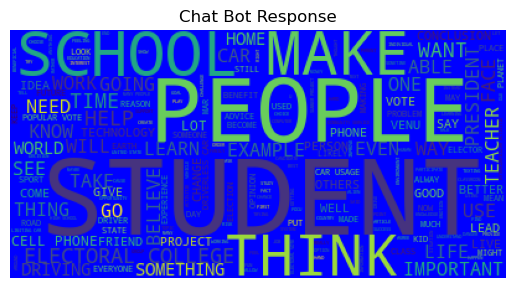

In [102]:
def cloud(text):
    wordcloud = WordCloud(background_color="blue").generate(" ".join([i for i in text.str.upper()]))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Chat Bot Response")
    
cloud(df["tokenized_text"])

## MODELLING


In [110]:
y = df.iloc[:1000]["label"]

X_train, X_test, y_train, y_test = train_test_split(X_top_100, y, test_size=0.25, random_state=42)

X_train = X_train.toarray() 
X_test = X_test.toarray() 

X_train_re = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_re = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_re.shape, X_test_re.shape,


((750, 100), (250, 100), (750,), (250,), (750, 1, 100), (250, 1, 100))

In [111]:
multinomial_nb = MultinomialNB(alpha=0.02)
multinomial_nb.fit(X_train, y_train)

MultinomialNB(alpha=0.02)

In [112]:
from sklearn.metrics import accuracy_score

y_pred_tra = multinomial_nb.predict(X_train)

y_pred = multinomial_nb.predict(X_test)

accuracy_score(y_train, y_pred_tra), accuracy_score(y_test, y_pred)

(0.804, 0.792)

In [113]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=128, input_shape=(1, input_shape), return_sequences=True))  # input_shape, (time_steps, features)
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


model = create_lstm_model(input_shape=X_train_re.shape[2])

C:\Users\Eren\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [114]:
model.fit(X_train_re, y_train, epochs=10, batch_size=32, validation_data=(X_test_re, y_test))


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7770 - loss: 0.6677 - val_accuracy: 0.7960 - val_loss: 0.5695
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8166 - loss: 0.5133 - val_accuracy: 0.7960 - val_loss: 0.4376
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8090 - loss: 0.4053 - val_accuracy: 0.7960 - val_loss: 0.3961
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8027 - loss: 0.3673 - val_accuracy: 0.7960 - val_loss: 0.3438
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8091 - loss: 0.2989 - val_accuracy: 0.8360 - val_loss: 0.2876
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8679 - loss: 0.2493 - val_accuracy: 0.8760 - val_loss: 0.2581
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9333 - loss: 0.1991 - val_accuracy: 0.9400 - val_loss: 0.2246
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9618 - loss: 0.1612 - val_accuracy: 0.9440 - val_loss